# 概要
- 永吉法・櫻井法・PSP法,3通りのAP解析を行い発生確率の比較を行う。

In [2]:
import ROOT as RT
from ROOT import std
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.colors import Normalize

In [3]:
#Cマクロの読み込み
#永吉法
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/dif_vol.h")
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/dif_vol_fit.h")
#櫻井法
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/single_Average_wave.h")
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/count_AP_sakurai.h")

#共通
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/shiki.h")
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/AP_charge_calc.h")

#PSP法
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/PSP.h")
RT.gROOT.LoadMacro("/Users/kiyomoto/reaserch/macro/AP_analysis/Charge_PSP.h")

0

# Single, Multiの解析結果

In [4]:
# 1p.e.のCharge, multiのCharge, MPの個数
single_pe = 13.24242424242424
#multi_pe = 3568
multi_pe = 1173.0
multi_event = 50000

# APの解析

In [5]:
#ファイル名,ツリー名
AP_file = "/Users/kiyomoto/reaserch/230111/AA2339_RTA4000/AP_source/ROOT_analysis/sample.root"
DK_file = "/Users/kiyomoto/reaserch/230111/AA2339_RTA4000/AP_dark/ROOT_analysis/sample.root"
tree = "AP"

In [6]:
#numpyでROOTファイルを読み込む
df = RT.RDataFrame("AP", AP_file)
npy = df.AsNumpy()

In [79]:
#ROOTファイルを開き描画する
file = RT.TFile.Open(AP_file)
tree_O = file.Get("AP")

Canvas Name=c1 Title=c1 Option=
 TCanvas fXlowNDC=0 fYlowNDC=0 fWNDC=1 fHNDC=1 Name= c1 Title= c1 Option=
  OBJ: TList	TList	Doubly linked list : 0
   TFrame  X1= -0.000000 Y1=-0.050000 X2=0.000003 Y2=0.350000
   OBJ: TH2F		23/01/11 AA2339 : 0 at: 0x7feb3d21e000
   OBJ: TPaveText	title  	X1= 0.000001 Y1=0.370000 X2=0.000002 Y2=0.397500


Info in <TCanvas::Print>: png file hoge.png has been created


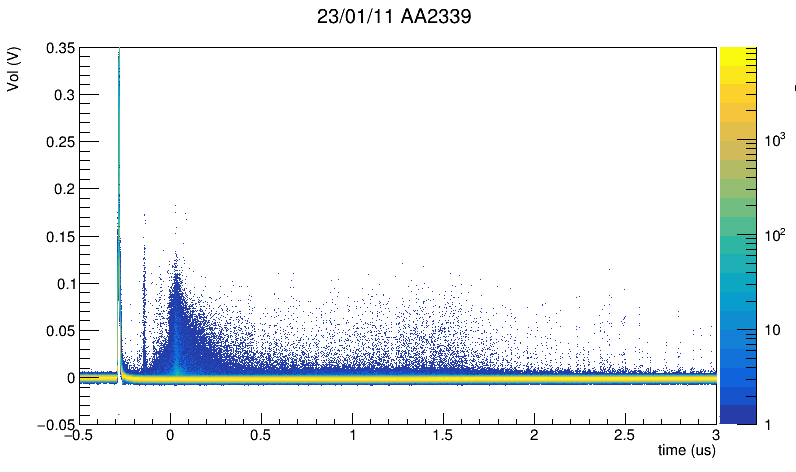

In [8]:
c1 = RT.TCanvas("c1", "c1", 800, 500)
#tree_O.Draw("wave:time")
tree_O.Draw("wave:time>>(4504,-0.5e-6,3e-6,1000,-0.05,0.35)","","colz", 50001, 0)
#ヒストグラムのオブジェクト名を入手
obj = c1.FindObject("")
obj.SetStats(0)
obj.SetTitle("23/01/11 AA2339;time (us);Vol (V);Counts")

c1.SetLogz()
c1.Draw()
c1.SaveAs("hoge.png")
c1.ls()

In [80]:
def calc_AP_rate(M_pe, S_pe, M_event, AP_pe_list, AP_event_list):
    bunbo = (M_pe/S_pe)*15*M_event
    bunshi = 0
    for i in range(len(AP_pe_list)):
        bunshi += AP_pe_list[i]
        #bunshi += AP_pe_list[i]* AP_event_list[i]
    AP_rate = bunshi / bunbo
    AP_total_counts = np.sum(np.array(AP_pe_list))
    MP_total_counts = M_event
    gosa = np.sqrt((1/AP_total_counts) + (1/MP_total_counts))*AP_rate
    print("MP p.e. is : " + str(bunbo) + " (event)")
    print("Total AP p.e. is : " + str(bunshi) + " (event)")
    print("AP_rate is : " + str(AP_rate))
    print("sigma : " + str(gosa))

## 永吉法

In [10]:
#微分波形のヒストグラム
hst2d = RT.threshold3(AP_file, tree, 500)

In [11]:
#微分した電圧のFittingパラメータ計算
para = RT.std.vector(float)()
para_err = RT.std.vector(float)()
RT.Fit_difVol(hst2d, para, para_err)

 FCN=1.96845e+07 FROM MIGRAD    STATUS=CONVERGED      81 CALLS          82 TOTAL
                     EDM=8.9451e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.31503e+07   1.20156e+03   2.10484e+03   8.97587e-08
   2  Mean         7.75799e-03   1.29742e-04   2.81013e-04   7.45810e+00
   3  Sigma        1.72830e+00   9.02881e-05   3.08600e-05   5.76176e+01


In [12]:
#Fitting関数の定義
def gau(x, p0, p1, p2):
    return p0*np.exp(-0.5*((x-p1)/p2)**2)

tmp_hist = [[], []]
#ヒストグラムのビンの数だけ繰り返す
for j in range(hst2d.GetNbinsX()):
    #ヒストグラムのビンの中心値を取得
    tmp_hist[0].append(hst2d.GetXaxis().GetBinCenter(j))
    #ヒストグラムのビンの高さを取得
    tmp_hist[1].append(hst2d.GetBinContent(j))

#データフレームに格納
tmp_df = pd.DataFrame(np.array(tmp_hist).T, columns=['X', 'Y'])

y_err = []
for m in range(len(tmp_df['Y'])):
    y_err.append(math.sqrt(tmp_df['Y'][m]))

three_sigme :5.184905290603638


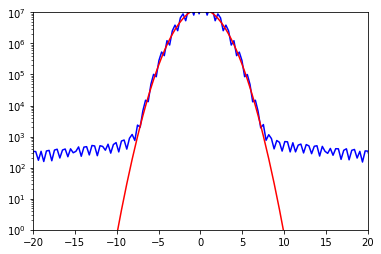

In [13]:
#Fitting結果
fig, ax = plt.subplots()
ax.plot(tmp_df["X"], tmp_df["Y"],c="blue", label="Charge Dist.", marker = '',linestyle="-")
ax.plot(tmp_df["X"],gau(tmp_df["X"], list(para)[0],list(para)[1],list(para)[2]),c="red",label="Best Fit")
#plt.errorbar(tmp_df["X"], tmp_df["Y"], yerr = y_err, capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
ax.set_yscale("log")
ax.set_ylim(1e0, 1e7)
ax.set_xlim(-20,20)

#thr = 1.01059*3
print("three_sigme :"+ str(list(para)[2]*3))
#plt.savefig("Gauss.png")

In [14]:
#微分波形が閾値を超えた点を全て計算
N_event = RT.std.vector(int)()
N_segment = RT.std.vector(int)()
N_vol = RT.std.vector(float)()
dif_vol = RT.std.vector(float)()
thr = list(para)[2]*3
RT.Dif_vol_Count(AP_file, tree, thr, N_event, N_segment, N_vol, dif_vol, 500)

In [15]:
#DataFrameに変換
#N_list = pd.DataFrame({'event':np.array(N_event), 'seg':np.array(N_segment), 'vol':np.array(N_vol), 'd_vol':np.array(dif_vol)})

In [16]:
#偏差が1点連続して超えたイベントだけ取り出す
N_ce = RT.std.vector(int)()
N_cs = RT.std.vector(int)()
N_cv = RT.std.vector(float)()
N_id = RT.std.vector(float)()
N_count = RT.std.vector(int)()
RT.Shki(N_event, N_segment, N_vol, dif_vol, N_ce, N_cs, N_cv, N_id, N_count, 2)

In [17]:
#電荷量を計算
N_charge = RT.std.vector(float)()
RT.clac_chrg(AP_file, tree, DK_file, tree, N_ce, N_cs, N_count, N_charge)

In [19]:
#DataFrameに変換
AP_nagayoshi = pd.DataFrame({'event':np.array(N_ce), 'seg':np.array(N_cs), 'peak_vol':np.array(N_cv)*1e3, 'charge':np.array(N_charge), 'pe':np.array(N_charge)/single_pe, 'Counts':np.array(N_count)})

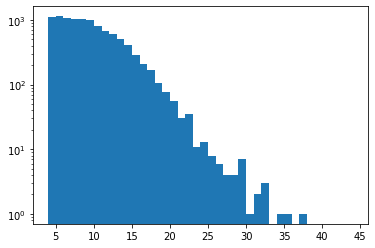

In [20]:
#AP_nagayoshie, 縦軸:カウントでヒストグラム
N_pe_hist = plt.hist(np.array(AP_nagayoshi["pe"]), bins = [m for m in range(4, 45)], log = True)

In [21]:
calc_AP_rate(multi_pe, single_pe, multi_event, N_pe_hist[0], N_pe_hist[1])

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10386.0 (event)
AP_rate is : 0.0001563351158645276
sigma : 1.685836722740002e-06


CONTINUOUS POINT:2
MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10386.0 (event)
AP_rate is : 0.0001563351158645276
sigma : 1.685836722740002e-06

CONTINUOUS POINT:3
MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 6186.0 (event)
AP_rate is : 9.311467617349968e-05
sigma : 1.2549956909965458e-06

CONTINUOUS POINT:4
MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 327.0 (event)
AP_rate is : 4.922162804515745e-06
sigma : 2.730848561706546e-07



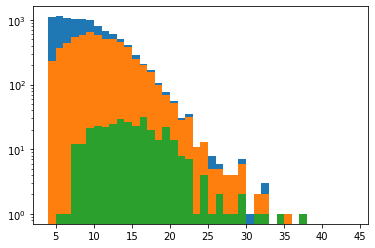

In [22]:
for i in range(2, 5, 1):
    N_ce = RT.std.vector(int)()
    N_cs = RT.std.vector(int)()
    N_cv = RT.std.vector(float)()
    N_id = RT.std.vector(float)()
    N_count = RT.std.vector(int)()
    RT.Shki(N_event, N_segment, N_vol, dif_vol, N_ce, N_cs, N_cv, N_id, N_count, i)
    
    N_charge = RT.std.vector(float)()
    RT.clac_chrg(AP_file, tree, DK_file, tree, N_ce, N_cs, N_count, N_charge)
    hist = plt.hist(np.array(N_charge)/single_pe, bins = [m for m in range(4, 45)], log = True)
    print("CONTINUOUS POINT:" + str(i))
    calc_AP_rate(multi_pe, single_pe, multi_event, hist[0], hist[1])
    print("")

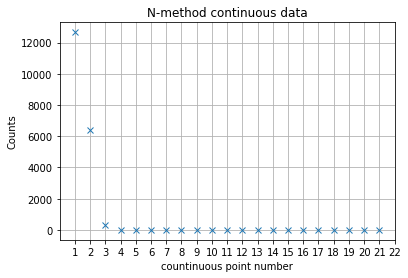

In [23]:
x2 = []
len_list2 = []
for m in range(22, 1, -1):
    x2.append(m-1)
    s_e = RT.std.vector(int)()
    s_s = RT.std.vector(int)()
    s_v = RT.std.vector(float)()
    s_id = RT.std.vector(float)()
    s_c = RT.std.vector(int)()
    RT.Shki(N_event, N_segment, N_vol, dif_vol, s_e, s_s, s_v, s_id, s_c, m)
    #RT.Shki(N_event, N_segment, N_vol, dif_vol, s_e, s_s, s_v, s_id, m)
    len_list2.append(len(np.array(s_e)))
    """
    if m == 22:
        len_list2.append(len(np.array(s_e)))
    else:
        len_list2.append(len(np.array(s_e)) - sum(len_list2))
        """
plt.plot(x2, len_list2, marker = "x", linestyle = " ")
plt.xticks(np.arange(1, 23, step=1))
plt.xlabel("countinuous point number")
plt.ylabel("Counts")
plt.title("N-method continuous data")
plt.grid()
plt.savefig("N_cont.png")

## 櫻井メソッド

In [7]:
#平均波形を計算
wave = RT.std.vector(float)()
time = RT.std.vector(float)()
RT.Average_Make_AP(AP_file, tree, 4504, wave, time)

In [25]:
#平均波形との偏差が閾値を超えた点を全て計算
sabun_thres = single_pe * 0.4
S_event = RT.std.vector(int)()
S_segment = RT.std.vector(int)()
S_vol = RT.std.vector(float)()
sabun = RT.std.vector(float)()
RT.count_sakurai(AP_file, tree, sabun_thres, sabun_thres, wave, S_event, S_segment, S_vol, sabun, 500)

In [26]:
#DataFrameに変換
#S_list = pd.DataFrame({'event':np.array(S_event), 'seg':np.array(S_segment), 'vol':np.array(S_vol)*1e3, 'sabun':np.array(sabun)})

In [27]:
#偏差が3点連続して超えたイベントだけ取り出す
S_ce = RT.std.vector(int)()
S_cs = RT.std.vector(int)()
S_cv = RT.std.vector(float)()
S_id = RT.std.vector(float)()
S_count = RT.std.vector(int)()
RT.Shki(S_event, S_segment, S_vol, sabun, S_ce, S_cs, S_cv, S_id, S_count, 4)

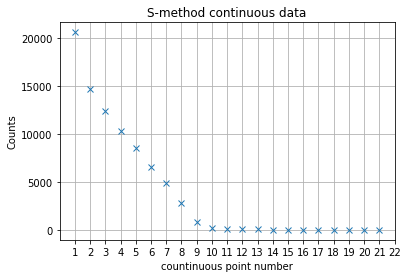

In [28]:
x = []
len_list = []
for m in range(22, 1, -1):
    x.append(m-1)
    t_e = RT.std.vector(int)()
    t_s = RT.std.vector(int)()
    t_v = RT.std.vector(float)()
    t_id = RT.std.vector(float)()
    t_c = RT.std.vector(int)()
    RT.Shki(S_event, S_segment, S_vol, sabun, t_e, t_s, t_v, t_id, t_c, m)
    len_list.append(len(np.array(t_e)))
    """
    if m == 22:
        len_list.append(len(np.array(t_e)))
    else:
        len_list.append(len(np.array(t_e)) - sum(len_list))
        """
        
plt.plot(x, len_list, marker = "x", linestyle = " ")
plt.xticks(np.arange(1, 23, step=1))
plt.xlabel("countinuous point number")
plt.ylabel("Counts")
plt.title("S-method continuous data")
plt.grid()
plt.savefig("S_cont.png")

In [29]:
#電荷量を計算
S_charge = RT.std.vector(float)()
RT.clac_chrg(AP_file, tree, DK_file, tree, S_ce, S_cs, S_count, S_charge)

In [30]:
#DataFrameに変換
AP_sakurai = pd.DataFrame({'event':np.array(S_ce), 'seg':np.array(S_cs), 'peak_vol':np.array(S_cv)*1e3, 'charge':np.array(S_charge), 'pe':np.array(S_charge)/single_pe, 'Counts':np.array(S_count)})

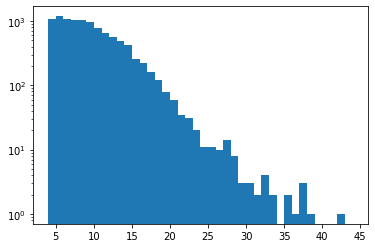

In [31]:
#横軸:pe, 縦軸:カウントでヒストグラム
S_pe_hist = plt.hist(np.array(AP_sakurai["pe"]), bins = [m for m in range(4, 45)], log = True)

In [32]:
calc_AP_rate(multi_pe, single_pe, multi_event, S_pe_hist[0], S_pe_hist[1])

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10274.0 (event)
AP_rate is : 0.00015464923747276685
sigma : 1.6751666064679743e-06


## PSP法

In [5]:
#識別に用いる閾値
thr = 5.184905290603638
sabun_thres = single_pe * 0.4

In [8]:
#ROOTファイルから実行
par = RT.std.vector(int)()
par2 = RT.std.vector(RT.std.vector(int))()
par3 = RT.std.vector(RT.std.vector(int))()
par4 = RT.std.vector(RT.std.vector(int))()
wf = RT.std.vector(RT.std.vector(int))()
par5 = RT.std.vector(RT.std.vector(float))()
df = RT.std.vector(RT.std.vector(int))()
par6 = RT.std.vector(RT.std.vector(float))()
par7 = RT.std.vector(int)()
par8 = RT.std.vector(int)()
par9 = RT.std.vector(int)()

start = 500
thres1 = thr
thres2 = sabun_thres
thres3 = thres1/3
thres4 = - thres2/2
thres =[thres1, thres2, thres3, thres4]

RT.scannig_wform(AP_file, tree, start, thres1, thres2, thres3, thres4, wave, par, par2, par3, par4, wf, par5, df, par6, par7, par8, par9)

In [9]:
def make_df(cont_length):
    
    event = []
    arm = [[], [], []]
    fall = [[], [], []]
    peak = [[], [], []]
    wfmax_s = [[], [], []]
    wfmax = [[], [], []]
    dfmax_s = [[], [], []]
    dfmax = [[], [], []]
    end = []
    qdf = []
    cont = []
    
    for i in range(len(par9)):
        if par9[i] == cont_length - 1:
            event.append(par[i])
            end.append(par7[i])
            qdf.append(par8[i])
            cont.append(par9[i])
            for m in range(0, cont_length):
                arm[m].append(par2[i][m])
                fall[m].append(par3[i][m])
                peak[m].append(par4[i][m])
                wfmax_s[m].append(wf[i][m])
                wfmax[m].append(par5[i][m])
                dfmax_s[m].append(df[i][m])
                dfmax[m].append(par6[i][m])
 
    PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont})
    
    if cont_length == 2:
        PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'arm_s2':arm[1], 'fall_s2':fall[1], 'peak_s2':peak[1], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'wfmax_slice2':wfmax_s[1], 'wfmax2':wfmax[1], 'dfmax_slice2':dfmax_s[1], 'dfmax2':dfmax[1], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont})
    elif cont_length == 3:
        PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'arm_s2':arm[1], 'fall_s2':fall[1], 'peak_s2':peak[1], 'arm_s3':arm[2], 'fall_s3':fall[2], 'peak_s3':peak[2], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'wfmax_slice2':wfmax_s[1], 'wfmax2':wfmax[1], 'dfmax_slice2':dfmax_s[1], 'dfmax2':dfmax[1], 'wfmax_slice3':wfmax_s[2], 'wfmax3':wfmax[2], 'dfmax_slice3':dfmax_s[2], 'dfmax3':dfmax[2], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont})
        
    return PSP_df

In [54]:
#par, par2, par3, par4, wf, par5, df, par6, par7, par8, par9
poppe1 = np.array(charge_list1)/single_pe

poppe21 = np.array(charge_list2[0])/single_pe
poppe22 = np.array(charge_list2[1])/single_pe

poppe31 = np.array(charge_list3[0])/single_pe
poppe32 = np.array(charge_list3[1])/single_pe
poppe33 = np.array(charge_list3[2])/single_pe
def make_all_df():
    
    event = []
    arm = []
    fall = []
    peak = []
    wfmax_s = []
    wfmax = []
    dfmax_s = []
    dfmax = []
    end = []
    qdf = []
    cont = []
    charge = []
    pe = []
    
    i1 = 0
    i2 = 0
    i3 = 0
    for i in range(len(par9)):
        if par9[i] == 0:
            kk = 1
            charge.append(charge_list1[i1])
            pe.append(poppe1[i1])
            i1 += 1
        elif par9[i] == 1:
            kk = 2
            charge.append(charge_list2[0][i2])
            charge.append(charge_list2[1][i2])
            pe.append(poppe21[i2])
            pe.append(poppe22[i2])
            i2 += 1
        elif par9[i] == 2:
            kk = 3
            charge.append(charge_list3[0][i3])
            charge.append(charge_list3[1][i3])
            charge.append(charge_list3[2][i3])
            pe.append(poppe31[i3])
            pe.append(poppe32[i3])
            pe.append(poppe33[i3])
            i3 += 1
        for m in range(0, kk):
            event.append(par[i])
            end.append(par7[i])
            qdf.append(par8[i])
            cont.append(par9[i])
            arm.append(par2[i][m])
            fall.append(par3[i][m])
            peak.append(par4[i][m])
            wfmax_s.append(wf[i][m])
            wfmax.append(par5[i][m])
            dfmax_s.append(df[i][m])
            dfmax.append(par6[i][m])
 
    PSP_df = pd.DataFrame({'event':event, 'arm_s':arm, 'fall_s':fall, 'peak_s':peak, 'wfmax_slice':wfmax_s, 'wfmax':wfmax, 'dfmax_slice':dfmax_s, 'dfmax':dfmax, 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont, "charge":charge, "pe":pe})

    return PSP_df

In [37]:
AP_PSP = make_all_df()

In [10]:
p = make_df(1)
pp = make_df(2)
ppp = make_df(3)

In [11]:
s_event = std.vector(int)(list(p["event"]))
s_s_silce = std.vector(int)(list(p["arm_s"]))
s_e_silce = std.vector(int)(list(p["end_slice"]))

s_charge = std.vector(float)()
RT.clac_chrg_PSP_1(AP_file, tree, DK_file, tree, s_event, s_s_silce, s_e_silce, s_charge)
charge_list1 = list(s_charge)

In [12]:
hage_fisa = ["arm_s", "arm_s2", "end_slice"]
charge_list2 = [[], []]
for m in range(0, 2, 1):
    s_event = std.vector(int)(list(pp["event"]))
    s_s_silce = std.vector(int)(list(pp[hage_fisa[m]]))
    s_e_silce = std.vector(int)(list(pp[hage_fisa[m+1]]))

    s_charge = std.vector(float)()
    RT.clac_chrg_PSP_1(AP_file, tree, DK_file, tree, s_event, s_s_silce, s_e_silce, s_charge)
    charge_list2[m] = list(s_charge)

In [13]:
hage_fisa = ["arm_s", "arm_s2", "arm_s3", "end_slice"]
charge_list3 = [[], [], []]
for m in range(0, 3, 1):
    s_event = std.vector(int)(list(ppp["event"]))
    s_s_silce = std.vector(int)(list(ppp[hage_fisa[m]]))
    s_e_silce = std.vector(int)(list(ppp[hage_fisa[m+1]]))

    s_charge = std.vector(float)()
    RT.clac_chrg_PSP_1(AP_file, tree, DK_file, tree, s_event, s_s_silce, s_e_silce, s_charge)
    charge_list3[m] = list(s_charge)

In [14]:
comb_slice = np.r_[p["wfmax_slice"], pp["wfmax_slice"], pp["wfmax_slice2"], ppp["wfmax_slice"], ppp["wfmax_slice2"],ppp["wfmax_slice3"]]
comb_pe = np.r_[charge_list1, charge_list2[0], charge_list2[1], charge_list3[0], charge_list3[1], charge_list3[2]]

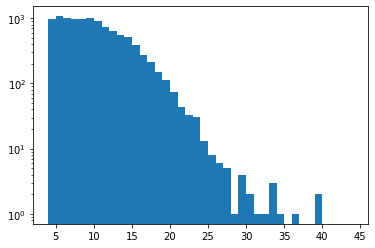

In [43]:
#横軸:pe, 縦軸:カウントでヒストグラム
PSP_pe_hist = plt.hist(comb_pe/single_pe, bins = [m for m in range(4, 45)], log = True)

In [44]:
calc_AP_rate(multi_pe, single_pe, multi_event, PSP_pe_hist[0], PSP_pe_hist[1])

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10765.0 (event)
AP_rate is : 0.00016204000792236083
sigma : 1.721698050130515e-06


In [45]:
def Show_pe_hist(x, title):
    plt.hist(x, bins = 100, log = True)
    plt.title(title)
    plt.xlabel("p.e.")
    plt.ylabel("Counts")
    plt.show()

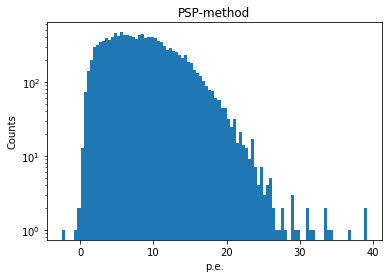

In [46]:
Show_pe_hist(comb_pe/single_pe, "PSP-method")

## Compare

In [85]:
def show_3D_hist(x, y, title):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111)

    H = ax.hist2d(x, y, bins=[np.linspace(450,4504,100),np.linspace(0,50,100)], norm=matplotlib.colors.LogNorm(), cmap=cm.jet)
    ax.set_title(title)
    ax.set_xlabel('segment_num (time)')
    ax.set_ylabel('p.e.')
    ax.axhline(4, color = "red")
    #ax.set_ylim(0, 15)

    fig.colorbar(H[3],ax=ax)
    H[3].set_clim(1e0,1e4)

    #fig.colorbar(H[3],ax=ax)
    plt.savefig(title + "_hist.png")
    plt.show()

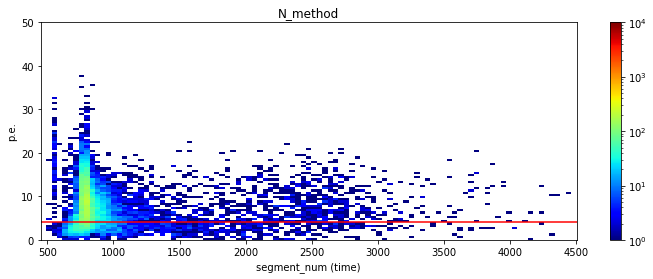

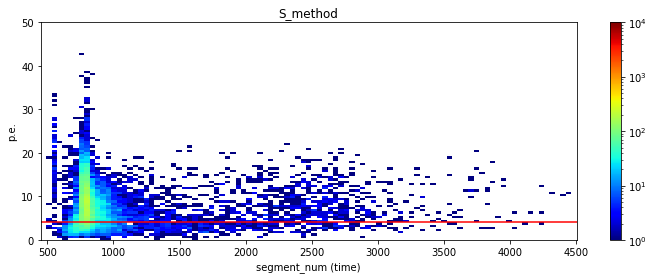

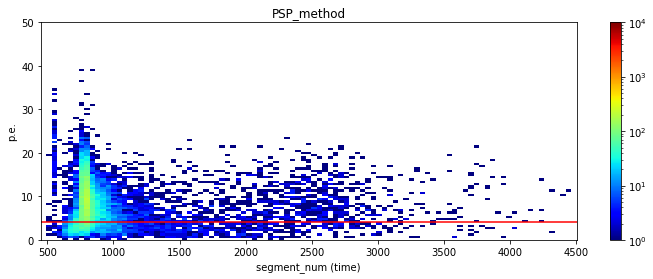

In [86]:
show_3D_hist(np.array(AP_nagayoshi["seg"]), np.array(AP_nagayoshi["pe"]), "N_method")
show_3D_hist(np.array(AP_sakurai["seg"]), np.array(AP_sakurai["pe"]), "S_method")
show_3D_hist(comb_slice, comb_pe/single_pe, "PSP_method")

In [49]:
def Show_time_hist(x, title):
    plt.hist(x, bins = 100, log = True)
    plt.title(title)
    plt.xlabel("segment_num (time)")
    plt.ylabel("Counts")
    plt.show()

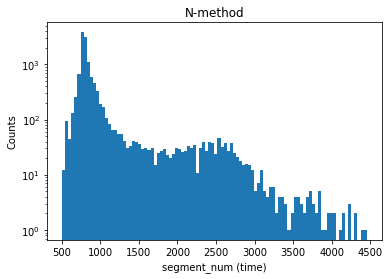

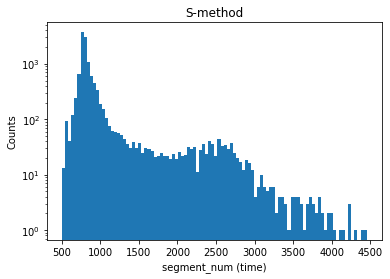

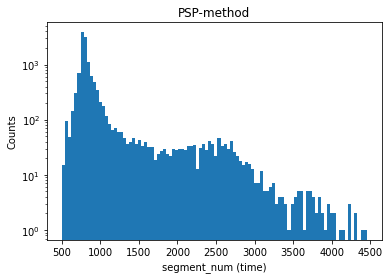

In [50]:
Show_time_hist(AP_nagayoshi["seg"], "N-method")
Show_time_hist(AP_sakurai["seg"], "S-method")
Show_time_hist(comb_slice, "PSP-method")

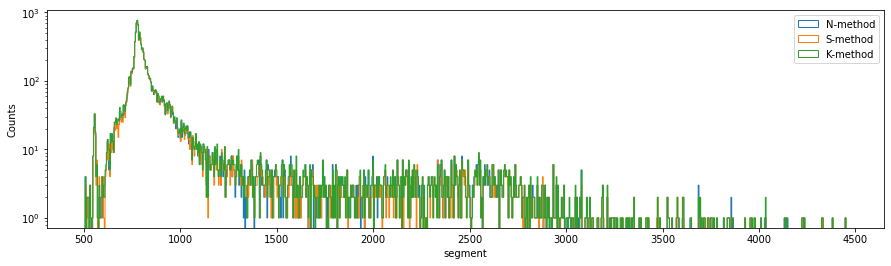

In [87]:
#横軸:pe, 縦軸:カウントでヒストグラム
fig = plt.figure(figsize=(15,4))
NSH = plt.hist(np.array(AP_nagayoshi["seg"]), bins = 1000, log = True, histtype='step', label = "N-method")
SSH = plt.hist(np.array(AP_sakurai["seg"]), bins = 1000, log = True, histtype='step', label = "S-method")
KSH = plt.hist(comb_slice, bins = 1000, log = True, histtype='step', label = "K-method")
#plt.xlim(1500, 3000)
plt.xlabel("segment")
plt.ylabel("Counts")
plt.legend()
plt.savefig("AP_time_dependent.png")

In [54]:
def Show_pe_hist(x, title):
    plt.hist(x, bins = 100, log = True)
    plt.title(title)
    plt.xlabel("p.e.")
    plt.ylabel("Counts")
    plt.axvline(4, color = "red")
    plt.savefig(title + ".png")
    plt.show()
    

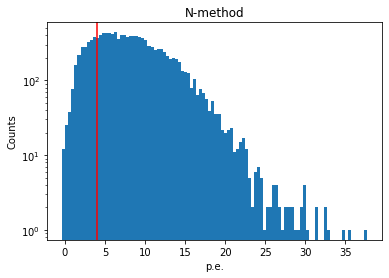

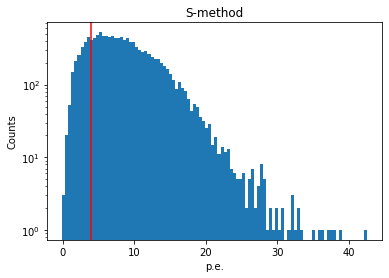

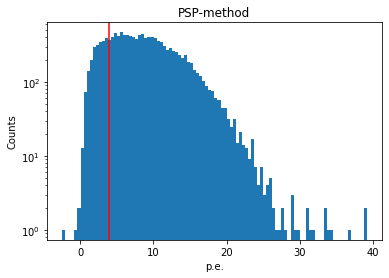

In [55]:
Show_pe_hist(AP_nagayoshi["pe"], "N-method")
Show_pe_hist(AP_sakurai["pe"], "S-method")
Show_pe_hist(comb_pe/single_pe, "PSP-method")

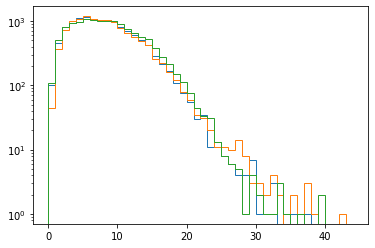

In [432]:
#横軸:pe, 縦軸:カウントでヒストグラム
NPH = plt.hist(np.array(AP_nagayoshi["pe"]), bins = [m for m in range(0, 45)], log = True, histtype='step')
SPH = plt.hist(np.array(AP_sakurai["pe"]), bins = [m for m in range(0, 45)], log = True, histtype='step')
PPH = plt.hist(comb_pe/single_pe, bins = [m for m in range(0, 45)], log = True, histtype='step')

In [434]:
NPH_e = []
SPH_e = []
PPH_e = []
for i in range(len(NPH[0])):
    if NPH[0][i] != 0:
        NPH_e.append(np.sqrt(NPH[0][i]))
    else:
        NPH_e.append(0)
        
for i in range(len(SPH[0])):
    if SPH[0][i] != 0:
        SPH_e.append(np.sqrt(SPH[0][i]))
    else:
        SPH_e.append(0)
        
for i in range(len(PPH[0])):
    if PPH[0][i] != 0:
        PPH_e.append(np.sqrt(PPH[0][i]))
    else:
        PPH_e.append(0)

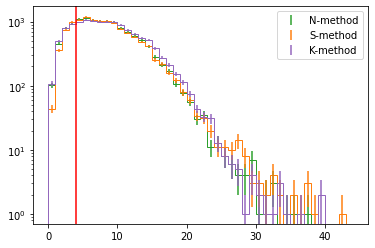

In [452]:
x = [i for i in range(0, 44)]
plt.hist(np.array(AP_nagayoshi["pe"]), bins = [m for m in range(0, 45)], log = True, histtype='step', color = "#2ca02c")
plt.hist(np.array(AP_sakurai["pe"]), bins = [m for m in range(0, 45)], log = True, histtype='step', color = "#ff7f0e")
plt.hist(comb_pe/single_pe, bins = [m for m in range(0, 45)], log = True, histtype='step', color = "#9467bd")
plt.errorbar(x_e, NPH[0], yerr = NPH_e, fmt= "None", markersize = 2.5, linestyle = "None", label = "N-method", color = "#2ca02c")
plt.errorbar(x_e, SPH[0], yerr = SPH_e, fmt = "None", linestyle = "None", label = "S-method", color = "#ff7f0e")
plt.errorbar(x_e, PPH[0], yerr = PPH_e, fmt = "None", linestyle = "None", label = "K-method", color = "#9467bd")
plt.axvline(4.0, color = "red")
plt.yscale('log')
#plt.ylim(0, 2*1e3)
plt.legend()
plt.savefig("all_counts.png")

In [403]:
plt.errorbar(x, y, yerr = y_err, capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='w')
coef=np.polyfit(x, y, 1)
a = np.array([1, 2, 3])

In [56]:
calc_AP_rate(multi_pe, single_pe, multi_event, N_pe_hist[0], N_pe_hist[1])
print("")
calc_AP_rate(multi_pe, single_pe, multi_event, S_pe_hist[0], S_pe_hist[1])
print("")
calc_AP_rate(multi_pe, single_pe, multi_event, PSP_pe_hist[0], PSP_pe_hist[1])

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10386.0 (event)
AP_rate is : 0.0001563351158645276
sigma : 1.685836722740002e-06

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10274.0 (event)
AP_rate is : 0.00015464923747276685
sigma : 1.6751666064679743e-06

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10765.0 (event)
AP_rate is : 0.00016204000792236083
sigma : 1.721698050130515e-06


In [24]:
p["charge"] = charge_list1

In [25]:
chibi = p[p["charge"] < 0]
chibi

,event,arm_s,fall_s,peak_s,wfmax_slice,wfmax,dfmax_slice,dfmax,end_slice,qdf,Pulse_cont,charge
415,1690,1267,1269,1270,1269,9.176821,1268,5.463409,1283,1,0,-0.614732
796,3167,1186,1187,1188,1187,12.499989,1186,8.006090,1215,1,0,-5.936708
4053,16287,835,836,837,837,19.530470,835,9.762186,884,1,0,-2.770725
4559,18187,858,860,861,860,21.091442,859,13.865840,923,1,0,-32.151176


In [333]:
[npy["time"][0][x] for x in range(start, end)]

[-5.815999770675262e-07,
 -5.80800019633898e-07,
 -5.80000005356851e-07,
 -5.79199991079804e-07,
 -5.78399976802757e-07,
 -5.776000193691289e-07,
 -5.768000050920818e-07,
 -5.759999908150348e-07,
 -5.751999765379878e-07,
 -5.744000191043597e-07]

In [365]:
def dif_vol(k, start, end):
    dif_value = []
    for i in range(start, end, 1):
        dif_value.append((np.array(npy["wave"][k])[i+1] - npy["wave"][k][i])*1e3)
    return dif_value

def plot_result(np_array, thers, wtype):
    
    #set_parameter
    start = int(np_array[1]) - 3
    #start = list(par2[i])[0]-5
    if wtype == 1:        
        end = int(np_array[8]) + 3
    elif wtype == 2:
        end = int(np_array[15]) + 3
    #end = par7[i] + 5
    
    ta = npy["time"][0]*1e9
    time_s = [ta[x] for x in range(start, end)]
    
    #描画設定
    #fig = plt.figure(figsize=(10, 8), facecolor='lightblue', linewidth=5, edgecolor='black')
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)    
    
    gre = "#7fff0066"
    ora = "#ff7f0066"
    blu = "#00ffff66"
    #wform描画
    #ax1.plot([x for x in range(start, end)], np.array(npy["wave"][int(np_array[0])])[start:end]*1e3, color = "red", marker = "x", label = "wform")
    ax1.plot(time_s, np.array(npy["wave"][int(np_array[0])])[start:end]*1e3, marker = "x", label = "wform")
    
    
    if wtype == 1:
        ax1.axvspan(ta[int(np_array[1])], int(np_array[2]), color = "lightgreen")
        ax1.axvspan(ta[int(np_array[2])], int(np_array[3]), color = "skyblue")
        ax1.axvspan(ta[int(np_array[3])], int(np_array[8]), color = "peachpuff")
        ax1.scatter(ta[int(np_array[4])], np_array[5], marker = "o", color = "#1f77b4")
    elif wtype == 2:
        ax1.axvspan(ta[int(np_array[1])], ta[int(np_array[2])], color = gre)
        ax1.axvspan(ta[int(np_array[2])], ta[int(np_array[3])], color = ora)
        ax1.axvspan(ta[int(np_array[3])], ta[int(np_array[4])], color = blu)
        ax1.axvspan(ta[int(np_array[4])], ta[int(np_array[5])], color = gre)
        ax1.axvspan(ta[int(np_array[5])], ta[int(np_array[6])], color = ora)
        ax1.axvspan(ta[int(np_array[6])], ta[int(np_array[15])], color = blu)
        ax1.scatter(ta[int(np_array[7])], np_array[8], marker = "o", color = "#1f77b4")
        ax1.scatter(ta[int(np_array[11])], np_array[12], marker = "o", color = "#1f77b4")
        
    elif wtype == 3:
        print("chi")
        
    t1 = "armed"
    t2 = "fall"
    t3 = "peakfind"
    #ax1.text(0.01, 0.99, t1, verticalalignment='top', transform=ax1.transAxes, fontsize = 15, color = "green")
    #ax1.text(0.01, 0.89, t2, verticalalignment='top', transform=ax1.transAxes, fontsize = 15, color = "skyblue")
    #ax1.text(0.01, 0.79, t3, verticalalignment='top', transform=ax1.transAxes, fontsize = 15, color = "orange")
    eve = "Event: " + str(int(np_array[0])) + " Seg: " + str(int(np_array[1])) + "~" + str(int(np_array[8]))
    #ax1.set_title(eve, fontsize = 15)
    #ax1.hlines(np.array(par5[i][0]), start, end, linestyle = "--")
    ax1.hlines(thers[1], ta[start], ta[end], linestyle = "--", color = "steelblue")
    ax1.axhspan(thers[3], 0, color = "lightgray")
    ax1.set_ylabel("vol (mV)")
    #ax1.legend()
    
    #ax2.plot([x for x in range(start, end)], dif_vol(int(np_array[0]), start, end), color = "blue", marker = "x", label = "derivative")
    ax2.plot(time_s, dif_vol(int(np_array[0]), start, end), marker = "x", color = "#2ca02c")
    
    if wtype == 1:
        ax2.axvspan(int(np_array[1]), int(np_array[2]), color = "lightgreen")
        ax2.axvspan(int(np_array[2]), int(np_array[3]), color = "skyblue")
        ax2.axvspan(int(np_array[3]), int(np_array[8]), color = "peachpuff")
        ax2.scatter(int(np_array[6]), np_array[7], marker = "o", color = "blue")
    elif wtype == 2:
        ax2.axvspan(ta[int(np_array[1])], ta[int(np_array[2])], color = gre)
        ax2.axvspan(ta[int(np_array[2])], ta[int(np_array[3])], color = ora)
        ax2.axvspan(ta[int(np_array[3])], ta[int(np_array[4])], color = blu)
        ax2.axvspan(ta[int(np_array[4])], ta[int(np_array[5])], color = gre)
        ax2.axvspan(ta[int(np_array[5])], ta[int(np_array[6])], color = ora)
        ax2.axvspan(ta[int(np_array[6])], ta[int(np_array[15])], color = blu)
        #ax2.scatter(int(np_array[9]), np_array[10], marker = "o", color = "blue")
        ax2.scatter(ta[int(np_array[9])], np_array[10], marker = "o", color = "#2ca02c")
        #ax2.scatter(int(np_array[13]), np_array[14], marker = "o", color = "blue")
        ax2.scatter(ta[int(np_array[13])], np_array[14], marker = "o", color = "#2ca02c")
        
    elif wtype == 3:
        print("chi")
        
    t1 = "armed"
    t2 = "fall"
    t3 = "peakfind"
    #ax2.text(0.01, 0.99, t1, verticalalignment='top', transform=ax2.transAxes, fontsize = 15, color = "lightgreen")
    #ax2.text(0.01, 0.89, t2, verticalalignment='top', transform=ax2.transAxes, fontsize = 15, color = "skyblue")
    #ax2.text(0.01, 0.79, t3, verticalalignment='top', transform=ax2.transAxes, fontsize = 15, color = "peachpuff")
    #eve = "Event: " + str(list(par)[i]) + " Seg: " + str(np.array(par2[i])[m]) + "~" + str(par7[i])
    ax2.hlines(thers[0], ta[start], ta[end], linestyle = "--", color = "steelblue")
    ax2.hlines(-thers[0], ta[start], ta[end], linestyle = "--", color = "steelblue")
    ax2.axhspan(-thers[2], thers[2], color = "lightgray")
    ax2.set_xlabel("slice")
    ax2.set_ylabel("derivative")
    #ax1.set_title(eve, fontsize = 15)
    #ax2.legend()
    
    plt.savefig("Double_event2.png")
    plt.show()

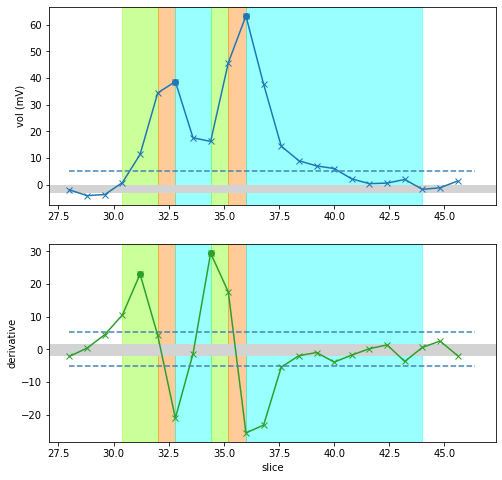

In [368]:
plot_result(np.array(pp)[3], thres, 2)

In [367]:
for i in range(len(chibi)):
    plot_result(np.array(chibi)[i], thres, 1)

NameError: name 'chibi' is not defined

In [21]:
pp

,event,arm_s,fall_s,peak_s,arm_s2,fall_s2,peak_s2,wfmax_slice,wfmax,dfmax_slice,dfmax,wfmax_slice2,wfmax2,dfmax_slice2,dfmax2,end_slice,qdf,Pulse_cont
0,287,786,788,789,794,796,797,789,52.341412,787,30.469481,797,61.524330,795,34.176796,807,0,1
1,436,768,770,771,780,782,783,771,34.176796,769,18.359737,783,63.280426,781,26.365828,793,0,1
2,572,775,778,779,781,782,783,778,67.579201,777,39.847523,783,66.018234,781,29.292654,793,0,1
3,959,775,777,778,780,781,782,778,38.670696,776,23.048759,782,63.280426,780,29.487778,792,0,1
4,989,855,858,859,861,862,863,858,74.804802,857,38.670692,862,43.359715,861,12.304867,873,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,48855,765,766,767,775,777,778,766,12.890232,765,8.786578,778,63.865795,776,28.121923,788,0,1
173,48962,772,774,775,783,785,786,774,74.414566,773,38.280453,786,34.573139,784,19.335348,796,0,1
174,49636,805,808,809,817,818,819,809,65.231644,807,40.231667,818,9.768283,817,5.274385,829,0,1
175,49777,775,778,779,787,789,790,778,83.006020,777,48.432880,790,67.188965,788,31.640213,800,0,1


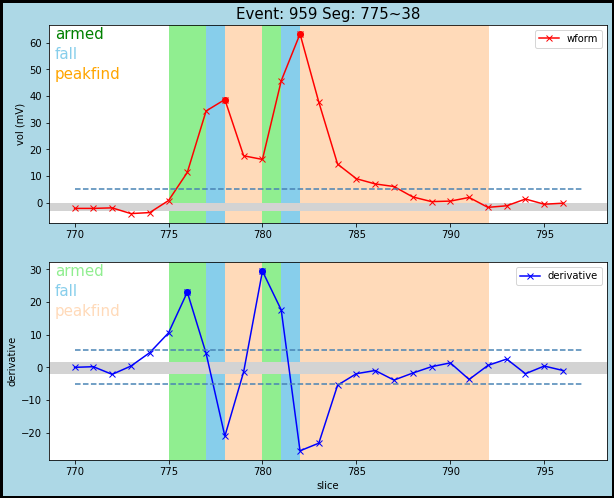

In [30]:
for i in range(3, 4, 1):
    plot_result(np.array(pp)[i], thres, 2)

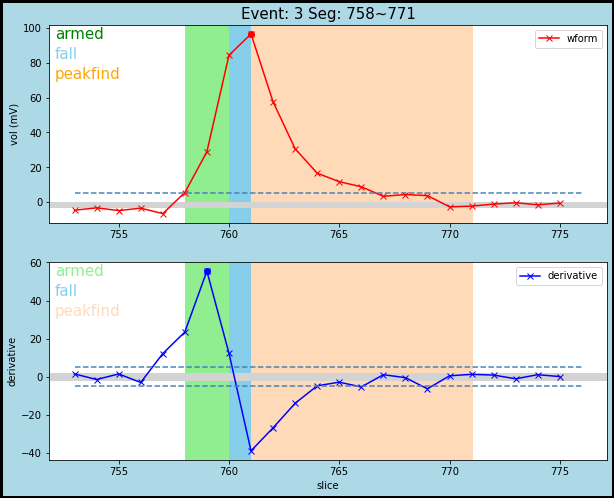

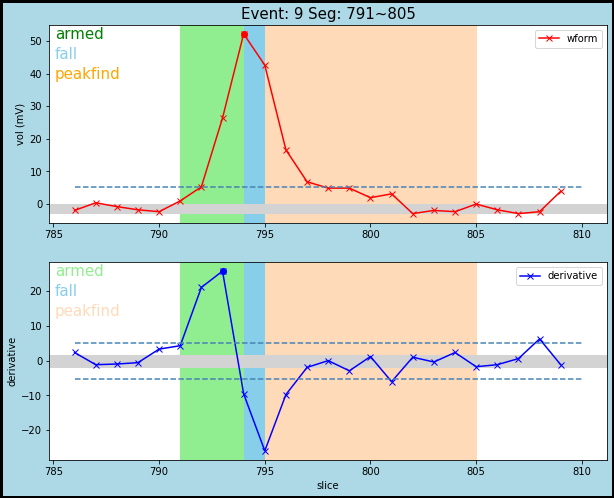

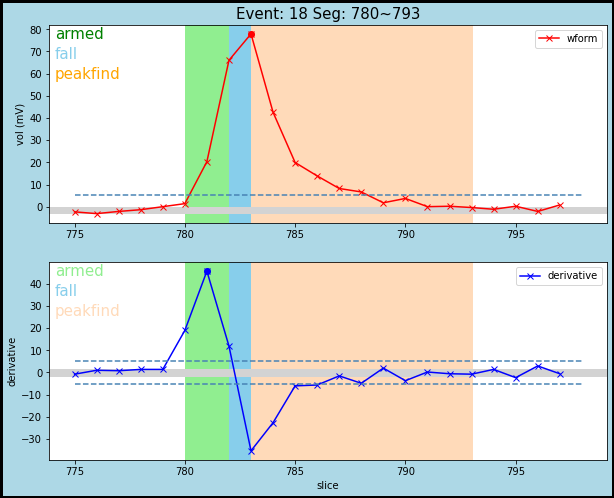

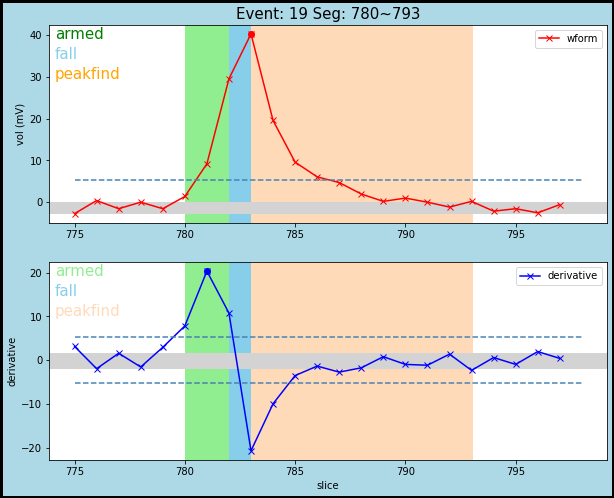

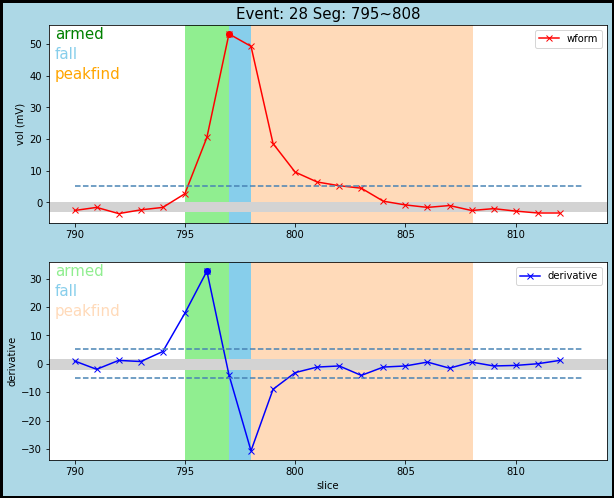

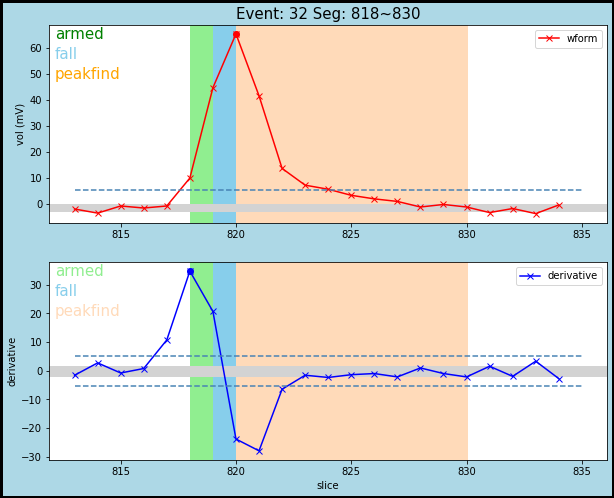

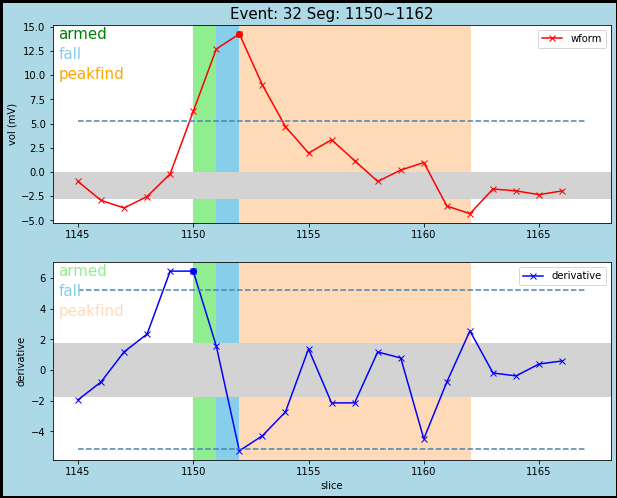

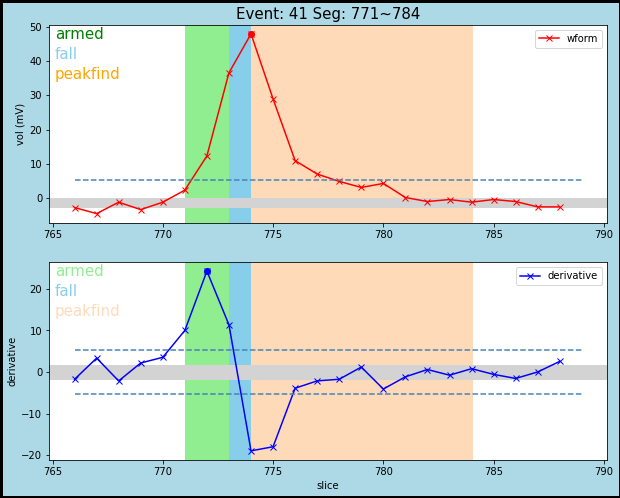

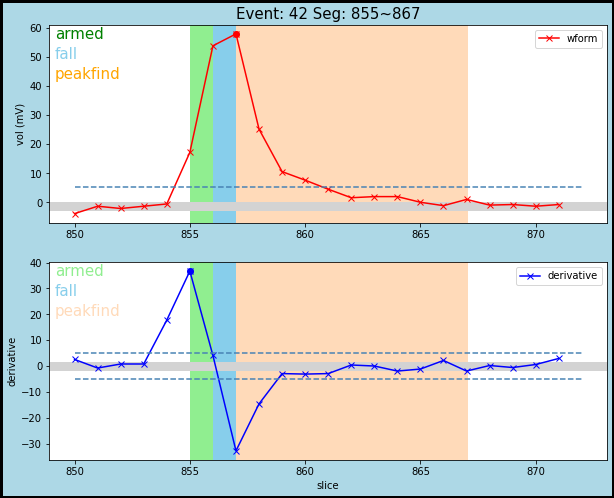

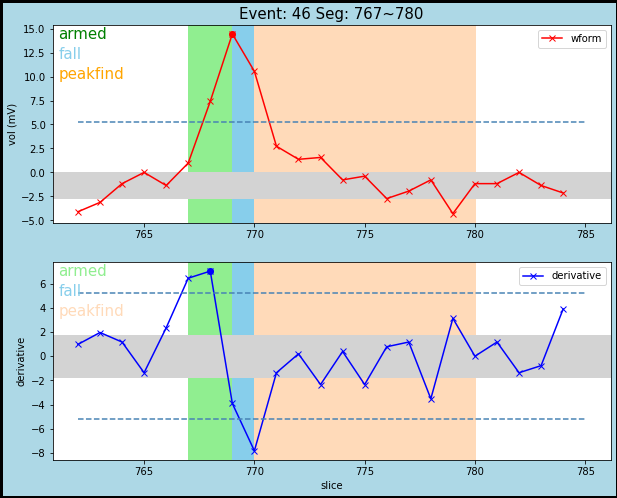

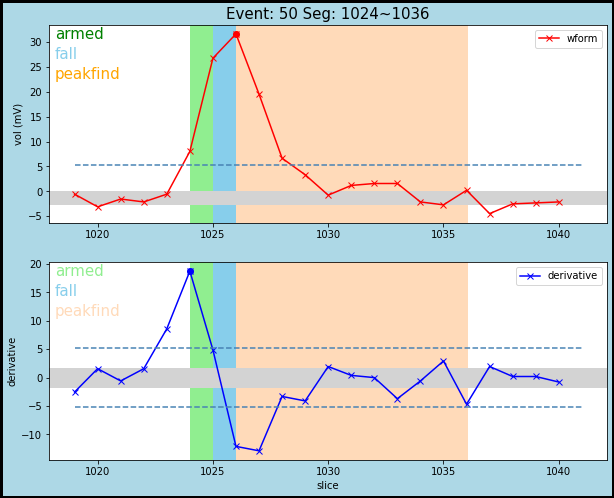

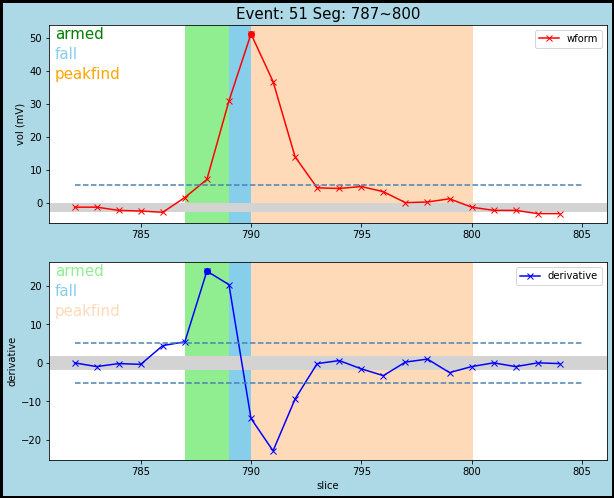

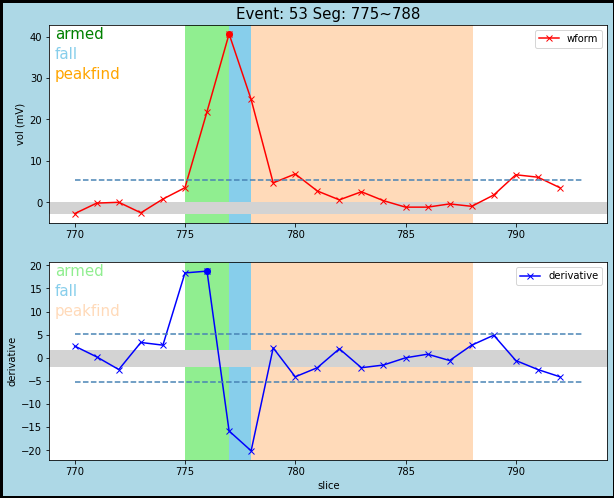

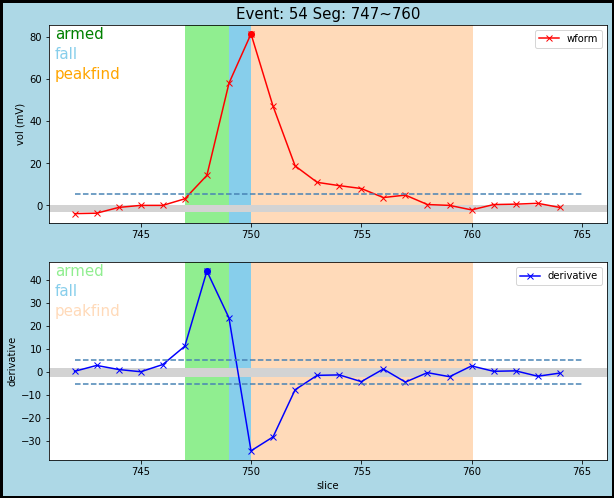

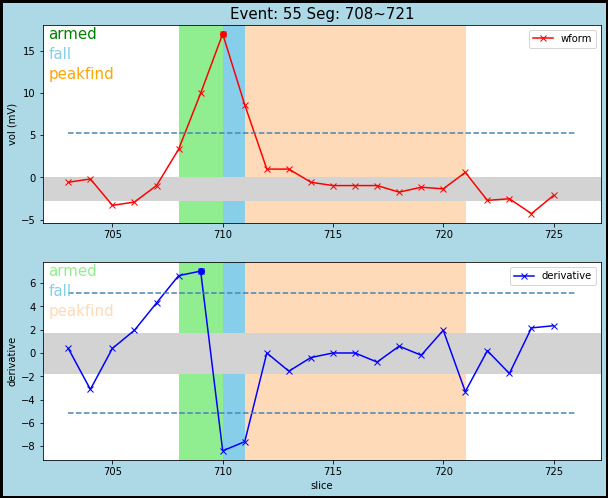

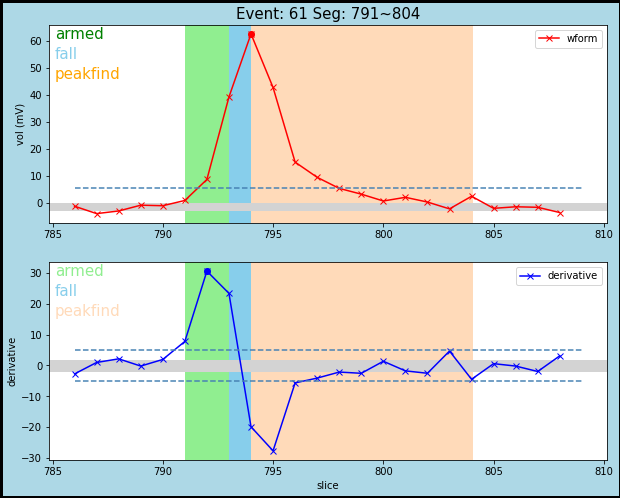

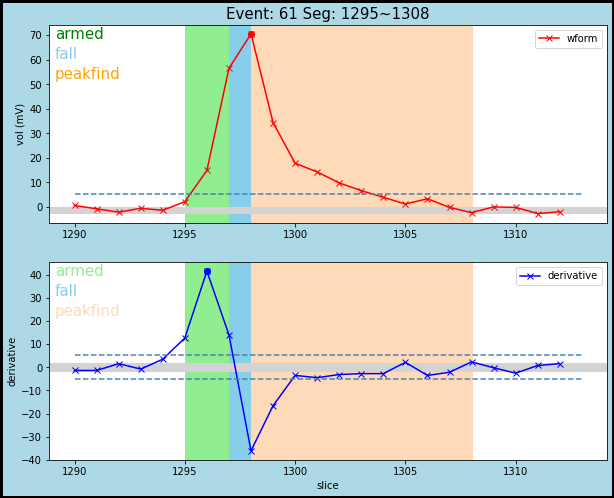

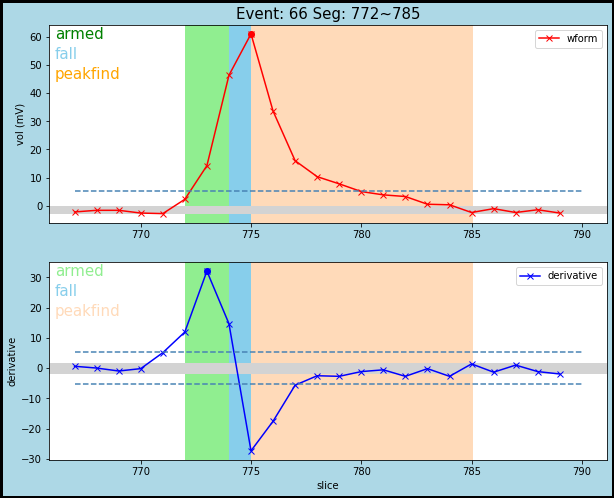

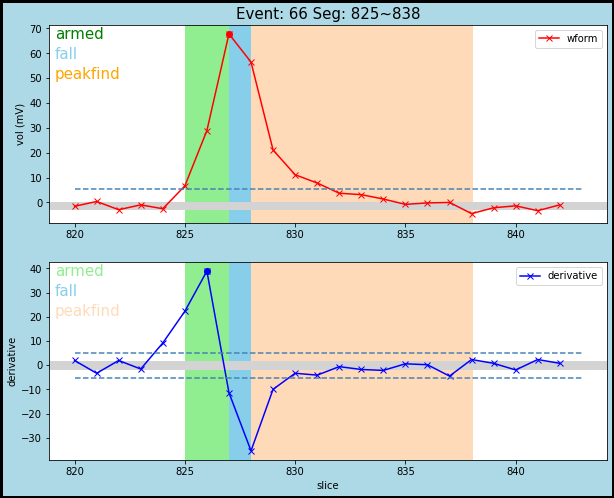

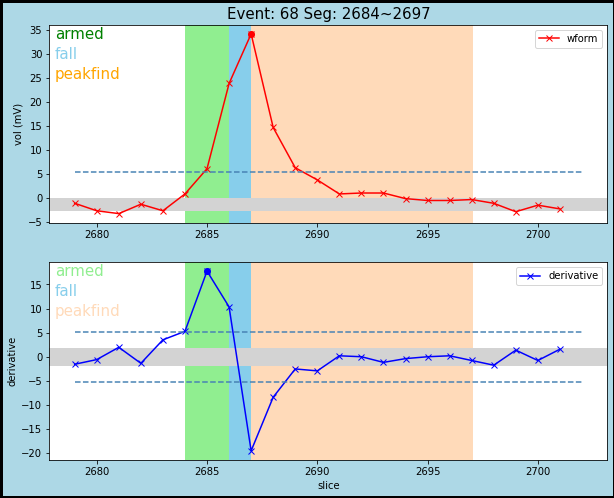

In [28]:
for i in range(20):
    plot_result(np.array(p)[i], thres, 1)

In [44]:
eem = list(p["event"])
for i in range(len(eem)-4):
    if eem[i] == eem[i+1] == eem[i+2] == eem[i+3] == eem[i+4]:
        print(i)
        print(eem[i])

5724
22853
7004
27958
8232
32646
11538
45422


(-10.0, 50.0)

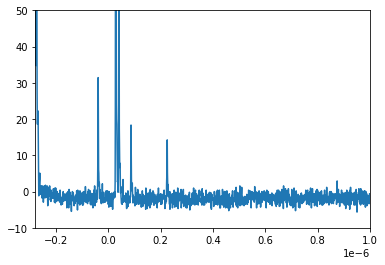

In [62]:
k = 32646
plt.plot(npy["time"][k], npy["wave"][k]*1e3)
plt.xlim(-0.28*1e-6, 1.0*1e-6)
plt.ylim(-10, 50)

In [32]:
ppp

,event,arm_s,fall_s,peak_s,arm_s2,fall_s2,peak_s2,arm_s3,fall_s3,peak_s3,...,wfmax2,dfmax_slice2,dfmax2,wfmax_slice3,wfmax3,dfmax_slice3,dfmax3,end_slice,qdf,Pulse_cont
0,8773,778,780,781,787,789,790,795,797,798,...,54.688972,788,32.030457,797,75.195053,796,33.591434,808,0,2
1,25318,768,770,771,777,780,781,789,791,792,...,75.390175,779,33.981678,792,76.756020,790,36.524357,802,0,2
2,25566,758,760,761,768,771,772,780,782,783,...,72.853584,770,30.469481,782,12.109745,781,5.859751,793,0,2
3,30274,764,766,767,774,776,777,784,786,787,...,33.201187,775,14.451205,786,61.524330,785,28.713387,797,0,2
4,33595,774,776,777,781,783,784,789,790,792,...,44.140202,782,20.310955,791,9.963406,789,5.859750,802,1,2
5,34656,779,781,782,788,790,791,795,796,797,...,77.536507,789,33.396313,797,45.115810,795,15.628035,807,0,2
6,34830,787,789,790,794,796,797,807,808,810,...,42.579227,795,15.237790,810,12.695110,807,6.640238,820,1,2
7,47248,768,769,770,780,782,783,784,785,786,...,48.243855,781,24.804853,786,86.524307,784,31.249966,796,0,2
8,48444,771,773,774,783,786,787,791,793,794,...,66.408470,785,34.768257,794,58.786530,792,31.054852,804,0,2


In [58]:
alpha1 = 3.6*1e-5
alpha2 = 3.3*1e-5
alpha3 = 4.2*1e-5

In [60]:
day = 6 + 2/12

In [63]:
print(alpha1 * day + 0.05*1e-3)
print(alpha2 * day + 0.05*1e-3)
print(alpha3 * day + 0.05*1e-3)

0.00027200000000000005
0.00025350000000000004
0.0003090000000000001


In [64]:
6*365+60

2250

In [73]:
6.1 * alpha3

0.0002562

In [75]:
calc_AP_rate(multi_pe, single_pe, multi_event, N_pe_hist[0], N_pe_hist[1])
print("")
calc_AP_rate(multi_pe, single_pe, multi_event, S_pe_hist[0], S_pe_hist[1])
print("")
calc_AP_rate(multi_pe, single_pe, multi_event, PSP_pe_hist[0], PSP_pe_hist[1])

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10386.0 (event)
AP_rate is : 0.0001563351158645276
sigma : 1.685836722740002e-06

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10274.0 (event)
AP_rate is : 0.00015464923747276685
sigma : 1.6751666064679743e-06

MP p.e. is : 66434210.5263158 (event)
Total AP p.e. is : 10765.0 (event)
AP_rate is : 0.00016204000792236083
sigma : 1.721698050130515e-06


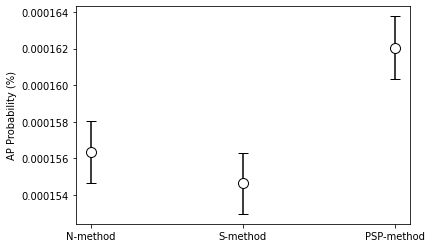

In [99]:
plt.errorbar(0, y= 0.0001563351158645276, yerr = 1.685836722740002e-06
, capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='w')
plt.errorbar(1, y= 0.00015464923747276685, yerr = 1.6751666064679743e-06
, capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='w')
plt.errorbar(2, y= 0.00016204000792236083, yerr = 1.721698050130515e-06
, capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='w')
plt.xticks([0, 1, 2], ["N-method", "S-method", "PSP-method"])
plt.ylabel("AP Probability (%)")
plt.savefig("AP_probability.png")

# 3手法での結果の差異

In [54]:
AP_sakurai

,event,seg,peak_vol,charge,pe,Counts
0,3,761,96.676735,247.663208,18.702257,8
1,9,794,52.146294,117.829155,8.897854,7
2,18,783,77.926758,196.253494,14.820058,7
3,19,783,40.231667,89.063332,6.725606,6
4,28,797,53.127998,115.643791,8.732826,7
...,...,...,...,...,...,...
12393,49973,1029,37.890205,87.185287,6.583786,6
12394,49974,1740,40.426792,95.933319,7.244393,6
12395,49976,735,56.054829,126.726700,9.569751,5
12396,49979,730,33.396313,74.531639,5.628247,5


In [55]:
AP_sakurai.to_pickle('./AP_sakurai.pkl')

In [57]:
AP_nagayoshi

,event,seg,peak_vol,charge,pe,Counts
0,3,760,84.377968,254.370514,19.208757,3
1,9,793,26.365829,120.941353,9.132872,1
2,18,782,66.018234,198.277878,14.972929,2
3,19,782,29.493874,93.282837,7.044242,2
4,28,796,20.506079,118.912086,8.979631,1
...,...,...,...,...,...,...
12659,49974,1541,9.176821,28.117548,2.123293,1
12660,49974,1739,15.036571,90.307304,6.819545,1
12661,49976,734,41.408497,126.409645,9.545809,2
12662,49979,729,22.658516,76.873100,5.805063,2


In [58]:
AP_nagayoshi.to_pickle('./AP_nagayoshi.pkl')

In [59]:
p

,event,arm_s,fall_s,peak_s,wfmax_slice,wfmax,dfmax_slice,dfmax,end_slice,qdf,Pulse_cont
0,3,758,760,761,761,96.676735,759,55.469456,771,0,0
1,9,791,794,795,794,52.146294,793,25.780464,805,0,0
2,18,780,782,783,783,77.926758,781,45.707279,793,0,0
3,19,780,782,783,783,40.231667,781,20.317053,793,0,0
4,28,795,797,798,797,53.127998,796,32.621922,808,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12716,49974,1540,1541,1542,1542,14.451206,1540,8.396333,1552,0,0
12717,49974,1738,1740,1741,1740,40.426792,1739,25.390219,1751,0,0
12718,49976,732,734,735,735,56.054829,733,26.957293,745,0,0
12719,49979,727,729,730,730,33.396313,728,15.432913,740,0,0


In [60]:
p.to_pickle('./AP_kiyomoto1.pkl')

In [61]:
pp

,event,arm_s,fall_s,peak_s,arm_s2,fall_s2,peak_s2,wfmax_slice,wfmax,dfmax_slice,dfmax,wfmax_slice2,wfmax2,dfmax_slice2,dfmax2,end_slice,qdf,Pulse_cont
0,287,786,788,789,794,796,797,789,52.341412,787,30.469481,797,61.524330,795,34.176796,807,0,1
1,436,768,770,771,780,782,783,771,34.176796,769,18.359737,783,63.280426,781,26.365828,793,0,1
2,572,775,778,779,781,782,783,778,67.579201,777,39.847523,783,66.018234,781,29.292654,793,0,1
3,959,775,777,778,780,781,782,778,38.670696,776,23.048759,782,63.280426,780,29.487778,792,0,1
4,989,855,858,859,861,862,863,858,74.804802,857,38.670692,862,43.359715,861,12.304867,873,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,48855,765,766,767,775,777,778,766,12.890232,765,8.786578,778,63.865795,776,28.121923,788,0,1
173,48962,772,774,775,783,785,786,774,74.414566,773,38.280453,786,34.573139,784,19.335348,796,0,1
174,49636,805,808,809,817,818,819,809,65.231644,807,40.231667,818,9.768283,817,5.274385,829,0,1
175,49777,775,778,779,787,789,790,778,83.006020,777,48.432880,790,67.188965,788,31.640213,800,0,1


In [62]:
pp.to_pickle('./AP_kiyomoto2.pkl')

In [63]:
ppp

,event,arm_s,fall_s,peak_s,arm_s2,fall_s2,peak_s2,arm_s3,fall_s3,peak_s3,...,wfmax2,dfmax_slice2,dfmax2,wfmax_slice3,wfmax3,dfmax_slice3,dfmax3,end_slice,qdf,Pulse_cont
0,8773,778,780,781,787,789,790,795,797,798,...,54.688972,788,32.030457,797,75.195053,796,33.591434,808,0,2
1,25318,768,770,771,777,780,781,789,791,792,...,75.390175,779,33.981678,792,76.756020,790,36.524357,802,0,2
2,25566,758,760,761,768,771,772,780,782,783,...,72.853584,770,30.469481,782,12.109745,781,5.859751,793,0,2
3,30274,764,766,767,774,776,777,784,786,787,...,33.201187,775,14.451205,786,61.524330,785,28.713387,797,0,2
4,33595,774,776,777,781,783,784,789,790,792,...,44.140202,782,20.310955,791,9.963406,789,5.859750,802,1,2
5,34656,779,781,782,788,790,791,795,796,797,...,77.536507,789,33.396313,797,45.115810,795,15.628035,807,0,2
6,34830,787,789,790,794,796,797,807,808,810,...,42.579227,795,15.237790,810,12.695110,807,6.640238,820,1,2
7,47248,768,769,770,780,782,783,784,785,786,...,48.243855,781,24.804853,786,86.524307,784,31.249966,796,0,2
8,48444,771,773,774,783,786,787,791,793,794,...,66.408470,785,34.768257,794,58.786530,792,31.054852,804,0,2


In [64]:
ppp.to_pickle('./AP_kiyomoto3.pkl')

In [70]:
AP_PSP

,event,arm_s,fall_s,peak_s,wfmax_slice,wfmax,dfmax_slice,dfmax,end_slice,qdf,Pulse_cont
0,3,758,760,761,761,96.676735,759,55.469456,771,0,0
1,9,791,794,795,794,52.146294,793,25.780464,805,0,0
2,18,780,782,783,783,77.926758,781,45.707279,793,0,0
3,19,780,782,783,783,40.231667,781,20.317053,793,0,0
4,28,795,797,798,797,53.127998,796,32.621922,808,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13097,49974,1540,1541,1542,1542,14.451206,1540,8.396333,1552,0,0
13098,49974,1738,1740,1741,1740,40.426792,1739,25.390219,1751,0,0
13099,49976,732,734,735,735,56.054829,733,26.957293,745,0,0
13100,49979,727,729,730,730,33.396313,728,15.432913,740,0,0


In [71]:
AP_PSP.to_pickle('./AP_kiyomoto.pkl')

In [69]:
N_e = list(AP_nagayoshi["event"])
S_e = list(AP_sakurai["event"])

In [53]:
diff_list = set(N_e) ^ set(S_e)
print(diff_list)
len(diff_list)

{46, 55, 32827, 101, 103, 113, 32910, 32973, 32991, 250, 33052, 33081, 362, 33159, 33261, 33283, 33319, 33337, 603, 621, 679, 33467, 788, 862, 877, 902, 33678, 33681, 966, 33769, 1082, 1110, 1177, 1198, 33967, 1211, 1235, 1280, 34085, 1368, 34186, 1435, 1436, 34246, 34298, 34304, 1575, 34372, 34433, 34441, 1682, 1696, 34490, 34508, 1777, 1811, 34607, 34657, 34681, 34740, 2057, 2093, 2146, 34970, 35039, 2274, 35048, 2296, 35065, 35074, 35102, 2338, 35189, 2456, 35239, 2473, 2471, 2505, 2544, 2591, 35412, 2660, 35448, 35484, 35501, 2753, 2774, 35544, 2795, 35607, 35661, 2932, 2952, 35728, 2979, 35751, 2984, 35762, 3007, 35783, 3110, 35880, 35887, 35903, 3167, 35996, 3251, 36036, 36037, 3282, 3438, 36251, 3491, 3550, 36344, 3602, 36388, 36402, 36422, 3697, 3735, 36512, 36547, 3785, 3845, 36643, 36684, 36691, 3941, 36841, 36842, 36863, 4282, 4315, 37098, 4374, 37193, 4483, 37292, 4551, 37446, 4729, 4753, 37547, 37605, 4871, 37656, 4910, 4915, 37701, 37720, 5039, 37871, 5121, 5182, 37992, 5

827

In [134]:
N_only = []
S_only = []
NS_comb = []
N_e = list(AP_nagayoshi["event"])
S_e = list(AP_sakurai["event"])
for i in range(13192):
    if N_e[i] < S_e[i]:
        print(str(i) + " ;N " + str(N_e[i]))
        S_e.insert(i, "x")
        N_only.append(N_e[i])
        NS_comb.append(N_e[i])
    elif N_e[i] > S_e[i]:
        print(str(i) + " ;S " + str(S_e[i]))
        N_e.insert(i, "x")
        S_only.append(S_e[i])
        NS_comb.append(S_e[i])
    else:
        NS_comb.append(N_e[i])

9 ;N 46
14 ;N 55
22 ;S 70
28 ;N 101
29 ;N 103
31 ;N 113
39 ;N 148
53 ;N 196
61 ;S 236
62 ;N 250
71 ;N 285
73 ;N 287
97 ;S 362
139 ;N 572
150 ;S 603
157 ;N 621
159 ;S 623
182 ;N 679
208 ;S 788
219 ;N 862
220 ;N 862
221 ;S 877
232 ;N 902
239 ;N 959
242 ;N 966
271 ;N 1082
284 ;N 1110
302 ;N 1177
305 ;N 1182
309 ;S 1193
311 ;S 1194
312 ;N 1198
315 ;N 1211
318 ;N 1235
337 ;N 1280
347 ;S 1368
353 ;N 1389
359 ;S 1435
360 ;N 1436
366 ;N 1445
373 ;S 1459
401 ;N 1575
414 ;N 1617
416 ;N 1623
426 ;S 1682
430 ;N 1696
445 ;S 1767
447 ;S 1777
449 ;S 1779
460 ;N 1811
515 ;N 2057
518 ;S 2059
533 ;S 2093
547 ;S 2146
578 ;N 2238
588 ;N 2274
590 ;N 2282
591 ;S 2296
597 ;S 2338
618 ;N 2445
620 ;S 2456
625 ;N 2471
626 ;S 2473
631 ;S 2505
640 ;N 2539
642 ;N 2544
653 ;N 2591
675 ;N 2660
702 ;N 2753
707 ;N 2765
709 ;S 2774
715 ;S 2795
743 ;N 2932
748 ;S 2952
757 ;S 2979
759 ;S 2984
766 ;N 3007
772 ;N 3026
792 ;N 3089
801 ;N 3110
813 ;N 3167
822 ;N 3201
842 ;N 3251
852 ;N 3282
873 ;N 3406
885 ;N 3438
897 ;S 349

In [112]:
print("N_only : " + str(len(N_only))) 
print("S_only : " + str(len(S_only))) 

N_only : 794
S_only : 528


In [114]:
len(S_e)

13192

In [157]:
def print_dif(i):
    print("N: " + str(N_e[i-5:i+5]))
    print("S: " + str(S_e[i-5:i+5]))
    print("P: " + str(P_e[i-5:i+5]))

In [87]:
print_dif(12721-5)

[48250, 48256, 48256, 48260, 48260, 48260, 48262, 48268, 48276, 48284]
[48248, 48249, 48250, 48256, 48260, 48260, 48260, 48262, 48268, 48276]


In [117]:
PSP_e = list(np.array(par))

In [135]:
PSP_e = list(np.array(par))
NS_only = []
PSP_only = []
for i in range(13390):
    if PSP_e[i] < NS_comb[i]:
        print(str(i) + " ;PSP " + str(PSP_e[i]))
        NS_comb.insert(i, "x")
        PSP_only.append(PSP_e[i])
        #NS_comb.append(N_e[i])
    elif PSP_e[i] > NS_comb[i]:
        print(str(i) + " ;NS " + str(NS_comb[i]))
        PSP_e.insert(i, "x")
        NS_only.append(NS_comb[i])
        #NS_comb.append(S_e[i])

36 ;PSP 126
41 ;PSP 148
57 ;PSP 214
64 ;NS 236
76 ;NS 287
93 ;PSP 343
103 ;PSP 363
121 ;NS 436
133 ;PSP 530
143 ;PSP 566
146 ;NS 572
215 ;NS 788
228 ;NS 877
231 ;PSP 879
247 ;NS 959
254 ;PSP 989
293 ;NS 1110
314 ;NS 1182
318 ;NS 1193
338 ;NS 1257
346 ;NS 1280
359 ;PSP 1374
381 ;NS 1454
409 ;NS 1568
436 ;NS 1682
439 ;PSP 1686
440 ;PSP 1690
442 ;NS 1696
447 ;PSP 1723
560 ;NS 2146
603 ;NS 2282
639 ;NS 2473
642 ;PSP 2484
643 ;PSP 2489
724 ;NS 2774
772 ;PSP 2977
775 ;NS 2984
817 ;NS 3110
857 ;NS 3249
858 ;NS 3251
868 ;NS 3282
910 ;NS 3475
913 ;NS 3491
926 ;NS 3549
941 ;NS 3602
947 ;NS 3619
1096 ;NS 4160
1110 ;NS 4227
1121 ;NS 4282
1142 ;NS 4374
1145 ;NS 4380
1185 ;NS 4551
1190 ;NS 4574
1245 ;NS 4763
1248 ;PSP 4778
1259 ;NS 4821
1283 ;NS 4910
1293 ;PSP 4933
1303 ;NS 4959
1314 ;PSP 5011
1324 ;NS 5039
1367 ;NS 5182
1409 ;NS 5370
1480 ;PSP 5628
1495 ;PSP 5695
1506 ;NS 5743
1519 ;PSP 5795
1534 ;NS 5863
1595 ;NS 6054
1617 ;NS 6155
1621 ;NS 6167
1645 ;NS 6255
1662 ;NS 6300
1668 ;NS 6329
1679 ;NS 6

IndexError: list index out of range

In [136]:
print("NS_only : " + str(len(NS_only))) 
print("PSP_only : " + str(len(PSP_only))) 

NS_only : 468
PSP_only : 183


In [152]:
N_only = []
S_only = []
P_only = []
NS_only = []
SP_only = []
PN_only = []

N_e = list(AP_nagayoshi["event"])
S_e = list(AP_sakurai["event"])
P_e = list(np.array(par))
for i in range(13400):
    if N_e[i] == S_e[i] and S_e[i] == P_e[i] and P_e[i] == N_e[i]:
        a = 10
    elif N_e[i] != S_e[i] and S_e[i] == P_e[i] and P_e[i] != N_e[i]:
        if S_e[i] > N_e[i]:   #2
            print(str(i) + " ;N " + str(N_e[i]))
            N_only.append(N_e[i])
            P_e.insert(i, "x")
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i]:   #5
            print(str(i) + " ;SP " + str(S_e[i]))
            SP_only.append(S_e[i])
            N_e.insert(i, "x")
            
    elif N_e[i] != S_e[i] and S_e[i] != P_e[i] and P_e[i] == N_e[i]:
        if S_e[i] > N_e[i]:   #6
            print(str(i) + " ;PN " + str(N_e[i]))
            PN_only.append(N_e[i])
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i]:   #3
            print(str(i) + " ;S " + str(S_e[i]))
            S_only.append(S_e[i])
            N_e.insert(i, "x")
            P_e.insert(i, "x")
    
    elif N_e[i] == S_e[i] and S_e[i] != P_e[i] and P_e[i] != N_e[i]:
        if S_e[i] > P_e[i]:   #4
            print(str(i) + " ;P " + str(P_e[i]))
            P_only.append(P_e[i])
            S_e.insert(i, "x")
            N_e.insert(i, "x")
        elif S_e[i] < P_e[i]:   #7
            print(str(i) + " ;NS " + str(N_e[i]))
            NS_only.append(S_e[i])
            P_e.insert(i, "x")
            
    elif N_e[i] != S_e[i] and S_e[i] != P_e[i] and P_e[i] != N_e[i]:
        if N_e[i] < S_e[i] and N_e[i] < P_e[i]:
            print(str(i) + " ;N " + str(N_e[i]))
            N_only.append(N_e[i])
            P_e.insert(i, "x")
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i] and S_e[i] < P_e[i]:
            print(str(i) + " ;S " + str(S_e[i]))
            S_only.append(S_e[i])
            N_e.insert(i, "x")
            P_e.insert(i, "x")
        elif P_e[i] < N_e[i] and P_e[i] < S_e[i]:
            print(str(i) + " ;P " + str(P_e[i]))
            P_only.append(P_e[i])
            S_e.insert(i, "x")
            N_e.insert(i, "x")

9 ;PN 46
14 ;PN 55
22 ;SP 70
28 ;PN 101
29 ;PN 103
31 ;PN 113
36 ;P 126
40 ;PN 148
41 ;P 148
55 ;PN 196
57 ;P 214
64 ;S 236
65 ;PN 250
74 ;PN 285
76 ;N 287
93 ;P 343
101 ;SP 362
103 ;P 363
121 ;NS 436
133 ;P 530
143 ;P 566
146 ;N 572
157 ;SP 603
164 ;PN 621
166 ;SP 623
189 ;PN 679
215 ;S 788
226 ;PN 862
227 ;PN 862
228 ;S 877
231 ;P 879
240 ;PN 902
247 ;N 959
250 ;PN 966
254 ;P 989
280 ;PN 1082
293 ;N 1110
311 ;PN 1177
314 ;N 1182
318 ;S 1193
320 ;SP 1194
321 ;PN 1198
324 ;PN 1211
327 ;PN 1235
338 ;NS 1257
346 ;N 1280
356 ;SP 1368
359 ;P 1374
363 ;PN 1389
369 ;SP 1435
370 ;PN 1436
376 ;PN 1445
381 ;NS 1454
383 ;SP 1459
409 ;NS 1568
411 ;PN 1575
424 ;PN 1617
426 ;PN 1623
436 ;S 1682
439 ;P 1686
440 ;P 1690
442 ;N 1696
447 ;P 1723
458 ;SP 1767
460 ;SP 1777
462 ;SP 1779
473 ;PN 1811
528 ;PN 2057
531 ;SP 2059
546 ;SP 2093
560 ;S 2146
591 ;PN 2238
601 ;PN 2274
603 ;N 2282
604 ;SP 2296
610 ;SP 2338
631 ;PN 2445
633 ;SP 2456
638 ;PN 2471
639 ;S 2473
642 ;P 2484
643 ;P 2489
646 ;SP 2505
655 ;P

IndexError: list index out of range

In [153]:
print("N_only : " + str(len(N_only)))
print("S_only : " + str(len(S_only)))
print("P_only : " + str(len(P_only)))
print("NS_only : " + str(len(NS_only))) 
print("SP_only : " + str(len(SP_only))) 
print("PN_only : " + str(len(PN_only))) 

N_only : 176
S_only : 197
P_only : 183
NS_only : 95
SP_only : 331
PN_only : 618


In [225]:
print_dif(12873)

N: [48171, 48173, 48176, 48181, 48194, 48196, 48197, 48200, 48206, 48209]
S: [48171, 48173, 48176, 48181, 48194, 'x', 48197, 48200, 48206, 48209]
P: [48171, 48173, 48176, 48181, 48194, 48196, 48197, 48200, 48206, 48209]


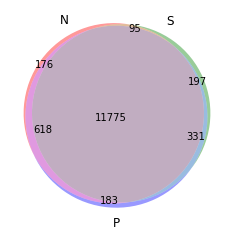

In [213]:
#!pip install matplotlib-venn
from matplotlib_venn import venn3
venn3(subsets = (176, 197, 95, 183, 618, 331, 11775), set_labels = ('N', 'S', 'P'))
plt.show()

In [163]:
N_eve = list(AP_nagayoshi["event"])
S_eve = list(AP_sakurai["event"])
P_eve = list(np.array(par))

In [237]:
print("N:" + str(len(N_eve)))
print("S:" + str(len(S_eve)))
print("P:" + str(len(P_eve)))

N:12664
S:12398
P:12907


(0.0, 135.0)

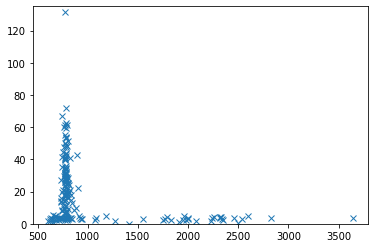

In [215]:
s = []
e = []
for i in range(len(N_only)):
    num = list(AP_nagayoshi["event"]).index(N_only[i])
    s.append(list(AP_nagayoshi["seg"])[num])
    e.append(list(AP_nagayoshi["peak_vol"])[num])
plt.plot(s,e, marker = "x", linestyle = " ")
plt.ylim(0, 135)

(0.0, 135.0)

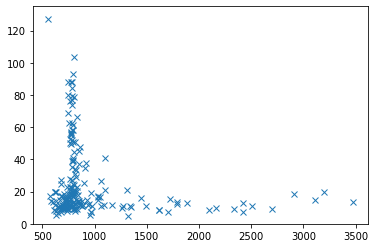

In [216]:
s = []
e = []
for i in range(len(S_only)):
    num = list(AP_sakurai["event"]).index(S_only[i])
    s.append(list(AP_sakurai["seg"])[num])
    e.append(list(AP_sakurai["peak_vol"])[num])
plt.plot(s,e, marker = "x", linestyle = " ")
plt.ylim(0, 135)

(0.0, 135.0)

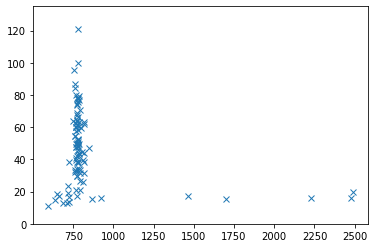

In [217]:
s = []
e = []
for i in range(len(NS_only)):
    num = list(AP_sakurai["event"]).index(NS_only[i])
    s.append(list(AP_sakurai["seg"])[num])
    e.append(list(AP_sakurai["peak_vol"])[num])
plt.plot(s,e, marker = "x", linestyle = " ")
plt.ylim(0, 135)

(0.0, 135.0)

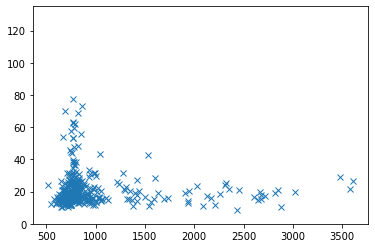

In [221]:
s = []
e = []
for i in range(len(SP_only)):
    num = list(AP_sakurai["event"]).index(SP_only[i])
    s.append(list(AP_sakurai["seg"])[num])
    e.append(list(AP_sakurai["peak_vol"])[num])
plt.plot(s,e, marker = "x", linestyle = " ")
plt.ylim(0, 135)

(0.0, 135.0)

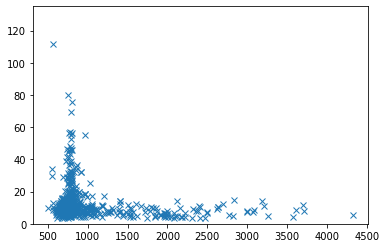

In [222]:
s = []
e = []
for i in range(len(PN_only)):
    num = list(AP_nagayoshi["event"]).index(PN_only[i])
    s.append(list(AP_nagayoshi["seg"])[num])
    e.append(list(AP_nagayoshi["peak_vol"])[num])
plt.plot(s,e, marker = "x", linestyle = " ")
plt.ylim(0, 135)

In [228]:
N4pe = AP_nagayoshi[AP_nagayoshi["pe"]>=4]

In [230]:
S4pe = AP_sakurai[AP_sakurai["pe"]>=4]

In [231]:
S4pe

,event,seg,peak_vol,charge,pe,Counts
0,3,761,96.676735,247.663208,18.702257,8
1,9,794,52.146294,117.829155,8.897854,7
2,18,783,77.926758,196.253494,14.820058,7
3,19,783,40.231667,89.063332,6.725606,6
4,28,797,53.127998,115.643791,8.732826,7
...,...,...,...,...,...,...
12393,49973,1029,37.890205,87.185287,6.583786,6
12394,49974,1740,40.426792,95.933319,7.244393,6
12395,49976,735,56.054829,126.726700,9.569751,5
12396,49979,730,33.396313,74.531639,5.628247,5


In [232]:
N4_only = []
S4_only = []
NS4_comb = []
N4_e = list(N4pe["event"])
S4_e = list(S4pe["event"])
for i in range(13192):
    if N4_e[i] < S4_e[i]:
        print(str(i) + " ;N " + str(N4_e[i]))
        S4_e.insert(i, "x")
        N4_only.append(N4_e[i])
        NS4_comb.append(N4_e[i])
    elif N4_e[i] > S4_e[i]:
        print(str(i) + " ;S " + str(S4_e[i]))
        N4_e.insert(i, "x")
        S4_only.append(S4_e[i])
        NS4_comb.append(S4_e[i])
    else:
        NS4_comb.append(N4_e[i])

51 ;N 287
109 ;N 572
175 ;N 862
178 ;N 881
191 ;N 959
247 ;N 1182
279 ;S 1368
286 ;N 1399
350 ;N 1740
358 ;S 1779
361 ;N 1784
473 ;N 2282
662 ;N 3201
707 ;S 3408
719 ;N 3451
735 ;S 3550
740 ;N 3570
789 ;N 3799
864 ;N 4130
871 ;N 4160
889 ;N 4246
902 ;S 4333
1022 ;S 4871
1042 ;S 4959
1091 ;N 5203
1130 ;N 5404
1132 ;N 5409
1133 ;N 5411
1163 ;N 5567
1169 ;N 5581
1222 ;N 5863
1243 ;S 5969
1285 ;S 6116
1347 ;N 6458
1371 ;S 6557
1377 ;N 6589
1395 ;S 6662
1422 ;N 6800
1425 ;N 6802
1496 ;S 7167
1695 ;N 8140
1724 ;S 8266
1767 ;N 8523
1823 ;S 8736
1830 ;N 8773
1849 ;S 8902
1863 ;S 8952
1974 ;N 9443
1989 ;N 9500
2035 ;S 9770
2076 ;N 9990
2083 ;N 10054
2121 ;S 10238
2165 ;N 10424
2182 ;N 10492
2204 ;N 10591
2223 ;S 10690
2246 ;N 10787
2254 ;N 10828
2281 ;S 10962
2371 ;N 11364
2385 ;S 11414
2408 ;N 11520
2443 ;N 11703
2609 ;S 12484
2642 ;N 12624
2667 ;S 12761
2692 ;N 12952
2697 ;N 12975
2732 ;N 13128
2795 ;N 13446
2812 ;S 13554
2870 ;N 13874
2910 ;N 14097
2919 ;N 14122
2951 ;N 14274
2954 ;N 14292
2

IndexError: list index out of range

In [233]:
print("N4_only : " + str(len(N4_only)))
print("S4_only : " + str(len(S4_only)))

N4_only : 208
S4_only : 96


In [234]:
S4_only

[1368,
 1779,
 3408,
 3550,
 4333,
 4871,
 4959,
 5969,
 6116,
 6557,
 6662,
 7167,
 8266,
 8736,
 8902,
 8952,
 9770,
 10238,
 10690,
 10962,
 11414,
 12484,
 12761,
 13554,
 15576,
 16667,
 16667,
 17381,
 18599,
 19198,
 19546,
 19798,
 20561,
 20819,
 21271,
 22560,
 23490,
 23856,
 24399,
 24987,
 25337,
 25383,
 26291,
 26407,
 26437,
 27361,
 27399,
 28524,
 28561,
 28750,
 29095,
 29444,
 29612,
 30477,
 30591,
 31922,
 32026,
 33537,
 33702,
 33778,
 34508,
 34967,
 35048,
 35421,
 35470,
 35494,
 35564,
 35667,
 35738,
 35833,
 37483,
 37620,
 38262,
 38376,
 38578,
 39360,
 39375,
 40072,
 41139,
 41442,
 41602,
 42818,
 43156,
 43989,
 44903,
 44925,
 46109,
 46434,
 46691,
 47243,
 47327,
 47444,
 48111,
 48972,
 49149,
 49342]

In [235]:
N4_only

[287,
 572,
 862,
 881,
 959,
 1182,
 1399,
 1740,
 1784,
 2282,
 3201,
 3451,
 3570,
 3799,
 4130,
 4160,
 4246,
 5203,
 5404,
 5409,
 5411,
 5567,
 5581,
 5863,
 6458,
 6589,
 6800,
 6802,
 8140,
 8523,
 8773,
 9443,
 9500,
 9990,
 10054,
 10424,
 10492,
 10591,
 10787,
 10828,
 11364,
 11520,
 11703,
 12624,
 12952,
 12975,
 13128,
 13446,
 13874,
 14097,
 14122,
 14274,
 14292,
 14365,
 14601,
 15104,
 15245,
 15430,
 15637,
 16489,
 16538,
 16637,
 16806,
 17442,
 17594,
 17707,
 17853,
 17948,
 18038,
 18045,
 18629,
 18950,
 19367,
 19395,
 19724,
 19883,
 20100,
 20207,
 20499,
 20549,
 20626,
 20841,
 20863,
 21202,
 21207,
 21396,
 21767,
 21780,
 21884,
 22404,
 22459,
 22799,
 22808,
 23172,
 23334,
 23712,
 23864,
 25078,
 25232,
 25268,
 25715,
 26069,
 26248,
 26947,
 27031,
 27098,
 27362,
 27672,
 27963,
 28090,
 28159,
 28213,
 28875,
 28898,
 28919,
 29116,
 29384,
 29457,
 29593,
 29636,
 29728,
 30030,
 30141,
 30178,
 30338,
 30579,
 30600,
 30653,
 32124,
 32171,

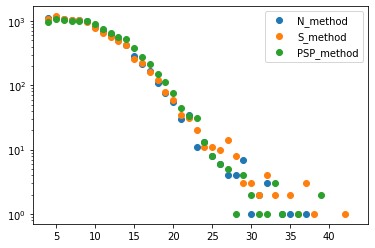

In [249]:
"""
print(N_pe_hist[0])
print(N_pe_hist[1])
print("")
print(S_pe_hist[0])
print(S_pe_hist[1])
print("")
print(PSP_pe_hist[0])
print(PSP_pe_hist[1])
"""
x = [i for i in range(4, 44, 1)]
plt.plot(x, N_pe_hist[0], linestyle = "None", marker = "o", label = "N_method")
plt.plot(x, S_pe_hist[0], linestyle = "None", marker = "o", label = "S_method")
plt.plot(x, PSP_pe_hist[0], linestyle = "None", marker = "o", label = "PSP_method")
plt.yscale('log')
plt.legend()

In [242]:
len(N_pe_hist[1])

41

In [243]:
x = [i for i in range(4, 44, 1)]

In [265]:
print(list(AP_sakurai["event"]).index(8773))
print(list(AP_nagayoshi["event"]).index(8773))
#list(pp["event"]).index(436)
#pp.iloc[1]

2144
2202


In [268]:
print(list(ppp["event"]))
AP_sakurai.iloc[2144:2148]

[8773, 25318, 25566, 30274, 33595, 34656, 34830, 47248, 48444]


,event,seg,peak_vol,charge,pe,Counts
2144,8773,780,45.701176,161.102280,12.165619,5
2145,8773,797,75.195053,464.219116,35.055450,17
2146,8784,787,75.195053,192.038864,14.501791,8
2147,8786,790,61.134090,139.697449,10.549235,8


In [269]:
AP_nagayoshi.iloc[2202:2206]

,event,seg,peak_vol,charge,pe,Counts
2202,8773,779,17.579252,102.658440,7.752239,2
2203,8773,789,48.829220,188.907135,14.265299,2
2204,8773,796,41.603619,292.185120,22.064323,1
2205,8784,786,38.280449,195.629105,14.772907,2


In [280]:
llist = []
for i in range(len(N4_only)):
    llist.append(list(AP_nagayoshi["event"]).index(N4_only[i]))
fumu = AP_nagayoshi.iloc[llist]

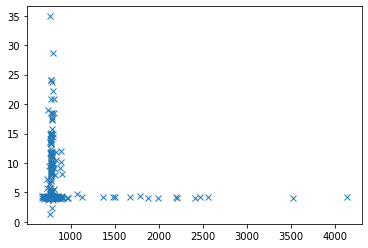

In [277]:
plt.plot(fumu["seg"], fumu["pe"], marker = "x", linestyle = "None")

In [281]:
llist = []
for i in range(len(S4_only)):
    llist.append(list(AP_sakurai["event"]).index(S4_only[i]))
fimu = AP_sakurai.iloc[llist]

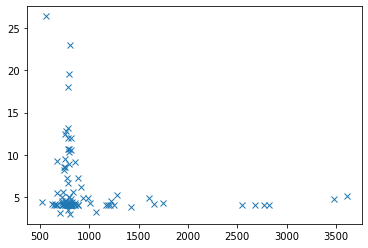

In [279]:
plt.plot(fimu["seg"], fimu["pe"], marker = "x", linestyle = "None")

In [282]:
fumu

,event,seg,peak_vol,charge,pe,Counts
70,287,787,17.384130,126.248665,9.533652,1
135,572,777,27.731682,275.941223,20.837667,2
213,862,787,7.615847,30.473145,2.301176,1
217,881,751,16.018276,53.136539,4.012599,1
231,959,776,11.329257,120.473061,9.097508,1
...,...,...,...,...,...,...
12298,48580,4134,19.335346,54.997990,4.153166,2
12345,48756,785,71.877975,236.716858,17.875645,2
12566,49643,2212,9.768283,54.693607,4.130181,1
12571,49658,837,20.506079,55.941414,4.224409,2


In [283]:
fimu

,event,seg,peak_vol,charge,pe,Counts
321,1368,664,23.634125,53.746296,4.058645,3
415,1779,675,53.908485,123.136467,9.298635,8
818,3408,704,20.310955,41.248741,3.114893,3
854,3550,992,31.445093,64.999947,4.908463,4
1050,4333,858,25.585340,53.912148,4.071169,4
...,...,...,...,...,...,...
11734,47444,793,24.414610,57.663364,4.354442,4
11915,48111,782,84.176750,238.438843,18.005680,8
12128,48972,836,30.859728,73.590179,5.557153,3
12169,49149,779,22.463392,53.126785,4.011863,3


In [284]:
print(list(fumu["event"]))

[287, 572, 862, 881, 959, 1182, 1399, 1740, 1784, 2282, 3201, 3451, 3570, 3799, 4130, 4160, 4246, 5203, 5404, 5409, 5411, 5567, 5581, 5863, 6458, 6589, 6800, 6802, 8140, 8523, 8773, 9443, 9500, 9990, 10054, 10424, 10492, 10591, 10787, 10828, 11364, 11520, 11703, 12624, 12952, 12975, 13128, 13446, 13874, 14097, 14122, 14274, 14292, 14365, 14601, 15104, 15245, 15430, 15637, 16489, 16538, 16637, 16806, 17442, 17594, 17707, 17853, 17948, 18038, 18045, 18629, 18950, 19367, 19395, 19724, 19883, 20100, 20207, 20499, 20549, 20626, 20841, 20863, 21202, 21207, 21396, 21767, 21780, 21884, 22404, 22459, 22799, 22808, 23172, 23334, 23712, 23864, 25078, 25232, 25268, 25715, 26069, 26248, 26947, 27031, 27098, 27362, 27672, 27963, 28090, 28159, 28213, 28875, 28898, 28919, 29116, 29384, 29457, 29593, 29636, 29728, 30030, 30141, 30178, 30338, 30579, 30600, 30653, 32124, 32171, 32401, 32966, 33321, 33667, 34486, 34656, 34656, 34782, 34830, 35108, 35269, 35452, 35460, 35796, 35842, 36047, 36298, 36335, 36

In [285]:
print(list(pp["event"]))

[287, 436, 572, 959, 989, 1182, 1257, 1454, 1554, 1568, 2282, 3249, 3420, 3549, 3619, 4160, 4227, 4763, 4959, 5030, 5863, 5960, 6097, 6243, 6255, 6447, 6589, 6640, 6662, 6704, 6802, 7100, 7932, 8140, 8188, 8732, 8952, 9500, 10204, 10336, 10591, 10778, 10787, 11961, 12122, 12263, 12892, 12975, 13908, 14122, 14365, 15245, 15254, 16250, 16300, 16306, 16482, 16612, 16637, 16806, 17095, 17490, 18045, 18308, 18695, 18950, 19288, 19724, 19883, 20231, 20549, 20863, 21207, 21482, 22955, 23261, 23334, 23562, 23712, 24027, 24681, 24792, 25033, 25078, 25232, 25349, 25639, 25665, 25715, 26069, 26263, 26305, 26437, 26864, 26947, 26999, 27239, 27564, 27786, 27788, 27835, 28090, 28213, 28285, 28875, 28923, 29116, 29201, 29302, 29728, 29882, 30178, 30338, 30444, 30579, 30591, 31133, 31168, 31762, 31863, 32661, 32801, 33321, 33667, 33791, 34486, 34937, 35108, 35300, 35421, 35470, 36047, 36335, 36693, 37131, 37253, 37619, 37897, 37897, 37989, 38318, 38704, 38773, 39290, 39323, 39567, 40301, 40892, 41826,

In [291]:
l1_l2_and = set(list(fumu["event"])) & set(list(ppp["event"]))

In [292]:
l1_l2_and

{8773, 34656, 34830, 47248, 48444}

In [288]:
len(l1_l2_and)

67

In [290]:
len(list(pp["event"]))

177

In [297]:
AP_PSP

,event,arm_s,fall_s,peak_s,wfmax_slice,wfmax,dfmax_slice,dfmax,end_slice,qdf,Pulse_cont
0,3,758,760,761,761,96.676735,759,55.469456,771,0,0
1,9,791,794,795,794,52.146294,793,25.780464,805,0,0
2,18,780,782,783,783,77.926758,781,45.707279,793,0,0
3,19,780,782,783,783,40.231667,781,20.317053,793,0,0
4,28,795,797,798,797,53.127998,796,32.621922,808,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13097,49974,1540,1541,1542,1542,14.451206,1540,8.396333,1552,0,0
13098,49974,1738,1740,1741,1740,40.426792,1739,25.390219,1751,0,0
13099,49976,732,734,735,735,56.054829,733,26.957293,745,0,0
13100,49979,727,729,730,730,33.396313,728,15.432913,740,0,0


In [471]:
N_only = []
S_only = []
P_only = []
NS_only = []
SP_only = []
PN_only = []

N_e = list(AP_nagayoshi["event"])
S_e = list(AP_sakurai["event"])
P_e = list(AP_PSP["event"])
print(len(N_e))
print(len(S_e))
print(len(P_e))
for i in range(13406):
    if N_e[i] == S_e[i] and S_e[i] == P_e[i] and P_e[i] == N_e[i]:
        a = 10
    elif N_e[i] != S_e[i] and S_e[i] == P_e[i] and P_e[i] != N_e[i]:
        if S_e[i] > N_e[i]:   #2
            print(str(i) + " ;N " + str(N_e[i]))
            N_only.append(N_e[i])
            P_e.insert(i, "x")
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i]:   #5
            print(str(i) + " ;SP " + str(S_e[i]))
            SP_only.append(S_e[i])
            N_e.insert(i, "x")
            
    elif N_e[i] != S_e[i] and S_e[i] != P_e[i] and P_e[i] == N_e[i]:
        if S_e[i] > N_e[i]:   #6
            print(str(i) + " ;PN " + str(N_e[i]))
            PN_only.append(N_e[i])
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i]:   #3
            print(str(i) + " ;S " + str(S_e[i]))
            S_only.append(S_e[i])
            N_e.insert(i, "x")
            P_e.insert(i, "x")
    
    elif N_e[i] == S_e[i] and S_e[i] != P_e[i] and P_e[i] != N_e[i]:
        if S_e[i] > P_e[i]:   #4
            print(str(i) + " ;P " + str(P_e[i]))
            P_only.append(P_e[i])
            S_e.insert(i, "x")
            N_e.insert(i, "x")
        elif S_e[i] < P_e[i]:   #7
            print(str(i) + " ;NS " + str(N_e[i]))
            NS_only.append(S_e[i])
            P_e.insert(i, "x")
            
    elif N_e[i] != S_e[i] and S_e[i] != P_e[i] and P_e[i] != N_e[i]:
        if N_e[i] < S_e[i] and N_e[i] < P_e[i]:
            print(str(i) + " ;N " + str(N_e[i]))
            N_only.append(N_e[i])
            P_e.insert(i, "x")
            S_e.insert(i, "x")
        elif S_e[i] < N_e[i] and S_e[i] < P_e[i]:
            print(str(i) + " ;S " + str(S_e[i]))
            S_only.append(S_e[i])
            N_e.insert(i, "x")
            P_e.insert(i, "x")
        elif P_e[i] < N_e[i] and P_e[i] < S_e[i]:
            print(str(i) + " ;P " + str(P_e[i]))
            P_only.append(P_e[i])
            S_e.insert(i, "x")
            N_e.insert(i, "x")

12664
12398
13102
9 ;PN 46
14 ;PN 55
22 ;SP 70
28 ;PN 101
29 ;PN 103
31 ;PN 113
36 ;P 126
40 ;PN 148
41 ;P 148
55 ;PN 196
57 ;P 214
64 ;S 236
65 ;PN 250
74 ;PN 285
76 ;PN 287
93 ;P 343
101 ;SP 362
103 ;P 363
133 ;P 530
143 ;P 566
146 ;PN 572
157 ;SP 603
164 ;PN 621
166 ;SP 623
189 ;PN 679
215 ;S 788
226 ;PN 862
227 ;PN 862
228 ;S 877
231 ;P 879
240 ;PN 902
247 ;PN 959
250 ;PN 966
254 ;P 989
255 ;P 989
281 ;PN 1082
294 ;N 1110
312 ;PN 1177
315 ;PN 1182
319 ;S 1193
321 ;SP 1194
322 ;PN 1198
325 ;PN 1211
328 ;PN 1235
347 ;N 1280
357 ;SP 1368
360 ;P 1374
364 ;PN 1389
370 ;SP 1435
371 ;PN 1436
377 ;PN 1445
384 ;SP 1459
408 ;P 1554
413 ;PN 1575
426 ;PN 1617
428 ;PN 1623
438 ;S 1682
441 ;P 1686
442 ;P 1690
444 ;N 1696
449 ;P 1723
460 ;SP 1767
462 ;SP 1777
464 ;SP 1779
475 ;PN 1811
530 ;PN 2057
533 ;SP 2059
548 ;SP 2093
562 ;S 2146
593 ;PN 2238
603 ;PN 2274
605 ;PN 2282
606 ;SP 2296
612 ;SP 2338
633 ;PN 2445
635 ;SP 2456
640 ;PN 2471
641 ;S 2473
644 ;P 2484
645 ;P 2489
648 ;SP 2505
657 ;PN 253

In [472]:
print("N_only : " + str(len(N_only)))
print("S_only : " + str(len(S_only)))
print("P_only : " + str(len(P_only)))
print("NS_only : " + str(len(NS_only))) 
print("SP_only : " + str(len(SP_only))) 
print("PN_only : " + str(len(PN_only))) 

N_only : 99
S_only : 189
P_only : 214
NS_only : 16
SP_only : 339
PN_only : 695


In [314]:
339 / 11855

0.02859552931252636

In [470]:
"""
N_e = list(AP_nagayoshi["event"])
S_e = list(AP_sakurai["event"])
P_e = list(AP_PSP["event"])
"""
print(len(N_e))
print(len(S_e))
print(len(P_e))

13406
13406
13406


In [456]:
13102 + 99 + 16 + 189

13406

In [457]:
12398 + 99 + 694 + 214

13405

In [458]:
def print_dif(i):
    print("N: " + str(N_e[i-5:i+5]))
    print("S: " + str(S_e[i-5:i+5]))
    print("P: " + str(P_e[i-5:i+5]))

In [469]:
print_dif(13402)

N: [49961, 49963, 49972, 49973, 49974, 49974, 49976, 49979, 49981]
S: [49961, 49963, 49972, 49973, 49974, 'x', 49976, 49979, 49981]
P: [49961, 49963, 49972, 49973, 49974, 49974, 49976, 49979, 49981]


In [478]:
(99 + 695 + 214) / 13406

0.07519021333731166

In [479]:
13406 - 11854 

1552

In [480]:
1152/ 13406

0.08593167238549904

In [481]:
print(NS_only)

[3475, 7318, 11472, 11511, 15197, 16180, 18157, 21200, 23271, 26264, 26596, 34388, 40186, 40398, 45238, 48008]


In [488]:
12664/(1-0.055)

13401.058201058202

In [486]:
13102/(1-0.023)

13410.440122824975

In [487]:
12398/(1-0.075)

13403.243243243243

# hoge?

In [48]:
poppe1 = np.array(charge_list1)/single_pe

poppe21 = np.array(charge_list2[0])/single_pe
poppe22 = np.array(charge_list2[1])/single_pe

poppe31 = np.array(charge_list3[0])/single_pe
poppe32 = np.array(charge_list3[1])/single_pe
poppe33 = np.array(charge_list3[2])/single_pe
def make_dfc(cont_length):
    
    event = []
    arm = [[], [], []]
    fall = [[], [], []]
    peak = [[], [], []]
    wfmax_s = [[], [], []]
    wfmax = [[], [], []]
    dfmax_s = [[], [], []]
    dfmax = [[], [], []]
    end = []
    qdf = []
    cont = []
    
    for i in range(len(par9)):
        if par9[i] == cont_length - 1:
            event.append(par[i])
            end.append(par7[i])
            qdf.append(par8[i])
            cont.append(par9[i])
            for m in range(0, cont_length):
                arm[m].append(par2[i][m])
                fall[m].append(par3[i][m])
                peak[m].append(par4[i][m])
                wfmax_s[m].append(wf[i][m])
                wfmax[m].append(par5[i][m])
                dfmax_s[m].append(df[i][m])
                dfmax[m].append(par6[i][m])
 
    if cont_length == 1:
        PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont, "charge":charge_list1, "pe":poppe1})
    
    elif cont_length == 2:
        PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'arm_s2':arm[1], 'fall_s2':fall[1], 'peak_s2':peak[1], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'wfmax_slice2':wfmax_s[1], 'wfmax2':wfmax[1], 'dfmax_slice2':dfmax_s[1], 'dfmax2':dfmax[1], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont, "charge1":charge_list2[0], "pe1":poppe21, "charge2":charge_list2[1], "pe2":poppe22})
    elif cont_length == 3:
        PSP_df = pd.DataFrame({'event':event, 'arm_s':arm[0], 'fall_s':fall[0], 'peak_s':peak[0], 'arm_s2':arm[1], 'fall_s2':fall[1], 'peak_s2':peak[1], 'arm_s3':arm[2], 'fall_s3':fall[2], 'peak_s3':peak[2], 'wfmax_slice':wfmax_s[0], 'wfmax':wfmax[0], 'dfmax_slice':dfmax_s[0], 'dfmax':dfmax[0], 'wfmax_slice2':wfmax_s[1], 'wfmax2':wfmax[1], 'dfmax_slice2':dfmax_s[1], 'dfmax2':dfmax[1], 'wfmax_slice3':wfmax_s[2], 'wfmax3':wfmax[2], 'dfmax_slice3':dfmax_s[2], 'dfmax3':dfmax[2], 'end_slice':end, 'qdf':qdf, 'Pulse_cont':cont, "charge1":charge_list3[0], "pe1":poppe31, "charge2":charge_list3[1], "pe2":poppe32, "charge3":charge_list3[2], "pe3":poppe33})
        
    return PSP_df

In [60]:
pow1 = make_dfc(1)
pow1.to_pickle('AP_kC1.pkl')

In [61]:
pow2 = make_dfc(2)
pow2.to_pickle('AP_kC2.pkl')

In [62]:
pow3 = make_dfc(3)
pow3.to_pickle('AP_kC3.pkl')

In [37]:
len(poppe22)

177

In [55]:
AP_PSPC = make_all_df()

In [63]:
AP_PSPC
AP_PSPC.to_pickle('AP_kC.pkl')

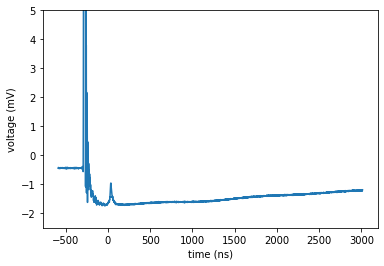

In [73]:
plt.plot(np.array(time)*1e9, wave)
plt.ylim(-2.5, 5.0)
plt.xlabel("time (ns)")
plt.ylabel("voltage (mV)")
plt.savefig("AP_a_wave.png")